# ECE 763 - Computer Vision - Project 03
## Babysitting the training of a Network

### mmsardes 

#### Import libraries
<p>Keras Sequential API was used to build the network. The CIFAR datasets was downloaded from keras datasets. 
Babysitting the training of a DNN is important as the final network performance depends a lot on how you set the hyper-parameters, how you initialize the weights, for how long you train the network etc. You don't want to over-train, or over-fit the model as it would lead to loss of generalization. General steps followed while training a DNN are 
1. Pre-process the Data and select Data Augmentation schemes. 
2. Choose architecture of the network 
3. Double check if the loss is reasonable. 
4. Hyperparameter tuning 
    </p>


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout, Reshape, BatchNormalization, Activation
from tensorflow.keras import optimizers, regularizers
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm

#### Import and preprocess the data. 
<p> Preprocessing scheme was standard scaling by subtracting mean and dividing by the standard deviation. A basic preprocessing operation is done by subtracting the mean and dividing by the standard deviation over the dataset. This is basically zero centering the data. This makes the model less sensitive to small changes in weights and makes it easier to optimize. It also reduces the effect of outliers to some extent as the range of the data is restricted. </p>

In [2]:
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
#conv to float
(X_train, y_train), (X_test, y_test)=(X_train.astype('float32'), y_train), (X_test.astype('float32'), y_test)
#class_names for cifar
class_name = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
num_classes = len(class_name)
preprocess_flag=True

In [3]:
def preprocess_data(X_train, X_test):
    X_train-=np.mean(X_train,axis=0)
    X_test-=np.mean(X_test,axis=0)
    X_train/=np.std(X_train,axis=0)
    X_test/=np.std(X_test,axis=0)
    return X_train, X_test
if preprocess_flag==True:
    X_train, X_test=preprocess_data(X_train, X_test)

In [4]:
#shape of the image data. 
iRows,iCols=X_train[0].shape[0],X_train[0].shape[1]

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

### Build the CNN 
<p> Here I have chosen a basic CNN with 3 layers. 32, 64, 128 filters in the three layers. All of them being 3x3 filters with a stride of 1. All the convolutional blocks are followed by 2x2 maxpool blocks. In the end the result is flattened and connected to a FCN with one hidden layer with 128 neurons and a softmax layer with 10 units as there are 10 classes in CIFAR. All the layers have 'relu' activations. The model is created using the Sequential API in Keras. Conditions are added to tweak the network if batchnormalization and dropout is desired.</p> 

In [6]:
#model hyperparam - Intial
LEARNING_RATE=1e-4
EPOCHS=10
L2_REG=0
BATCH_SIZE=32
DROPOUT=0.5

In [7]:
#Function to create model according to given conditions. 
def create_model(num_clases,L2_REG, drop=False, bnorm=False):
    model = Sequential()
    if drop==True:
        model.add(Conv2D(filters=32, kernel_size=(3,3), padding= 'same', activation='relu',input_shape = (iRows, iCols,3)))
        model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))
        model.add(Dropout(DROPOUT))
        model.add(Conv2D(filters=64, kernel_size=(3,3), padding= 'same', activation='relu',kernel_regularizer=regularizers.l2(L2_REG), bias_regularizer=regularizers.l2(L2_REG)))
        model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))

        model.add(Conv2D(filters=128, kernel_size=(3,3), padding= 'same', activation='relu', kernel_regularizer=regularizers.l2(L2_REG), bias_regularizer=regularizers.l2(L2_REG)))
        model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))
        model.add(Dropout(DROPOUT))

        model.add(Flatten())
        model.add(Dense(units = 128, activation='relu', kernel_regularizer=regularizers.l2(L2_REG), bias_regularizer=regularizers.l2(L2_REG)))
        model.add(Dense(units=num_classes,activation='softmax'))
    elif bnorm==True:
        model.add(Conv2D(filters=32, kernel_size=(3,3), padding= 'same',input_shape = (iRows, iCols,3)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))
        
        model.add(Conv2D(filters=64, kernel_size=(3,3), padding= 'same', kernel_regularizer=regularizers.l2(L2_REG), use_bias=False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))

        model.add(Conv2D(filters=128, kernel_size=(3,3), padding= 'same', kernel_regularizer=regularizers.l2(L2_REG), use_bias=False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))

        model.add(Flatten())
        model.add(Dense(units = 128, kernel_regularizer=regularizers.l2(L2_REG), use_bias=False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dense(units=num_classes,activation='softmax'))
    else:
        model.add(Conv2D(filters=32, kernel_size=(3,3), padding= 'same', activation='relu',input_shape = (iRows, iCols,3)))
        model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))
    
        model.add(Conv2D(filters=64, kernel_size=(3,3), padding= 'same', activation='relu',kernel_regularizer=regularizers.l2(L2_REG), bias_regularizer=regularizers.l2(L2_REG)))
        model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))

        model.add(Conv2D(filters=128, kernel_size=(3,3), padding= 'same', activation='relu', kernel_regularizer=regularizers.l2(L2_REG), bias_regularizer=regularizers.l2(L2_REG)))
        model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))

        model.add(Flatten())
        model.add(Dense(units = 128, activation='relu', kernel_regularizer=regularizers.l2(L2_REG), bias_regularizer=regularizers.l2(L2_REG)))
        model.add(Dense(units=num_classes,activation='softmax'))
    return model 

In [8]:
model=create_model(num_classes,L2_REG)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________

#### Compile and evaluate the Initial loss as a sanity check 
<p> The initial loss should come up to be around 2.3 for 10 classes with no regularization applied. </p>

In [9]:
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [10]:
model.evaluate(X_train,y_train)

37500/37500 [==============================] - 4s 103us/sample - loss: 2.3217 - sparse_categorical_accuracy: 0.1025s - loss: 2.3222 - spar


[2.3217368571217856, 0.10253333]

#### Crank up regularization 
Sanity check: If we crank up the regularization we get a higher loss as expected. 

In [11]:
#model hyperparam
LEARNING_RATE=1e-4
EPOCHS=10
L2_REG=1e3

model=create_model(num_classes,L2_REG)
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
model.evaluate(X_train, y_train)

37500/37500 [==============================] - 3s 67us/sample - loss: 369954.6348 - sparse_categorical_accuracy: 0.0990


[369954.63481, 0.099013336]

#### Try to overfit a small portion of data. 
We try to overfit the small portion of the data as a sanity check with no regularization and vanilla SGD optimizer. This ensures that our model is actually learning and the loss is going down. We verify this using the training accuracy (It should reach 100% theoretically). We can also see that the model reaches a very small loss as we reach the last epoch. That's a good sanity check. 

In [14]:
#model hyperparam
LEARNING_RATE=1e-3
EPOCHS=100
L2_REG=0

X_tiny=X_train[:20]
y_tiny=y_train[:20]


In [15]:
model=create_model(num_classes,L2_REG)
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
history = model.fit(X_tiny,y_tiny,batch_size=2,epochs=EPOCHS, verbose=1)

Train on 20 samples
Epoch 1/100
20/20 [==============================] - 0s 4ms/sample - loss: 2.3171 - sparse_categorical_accuracy: 0.0500
Epoch 2/100
20/20 [==============================] - 0s 2ms/sample - loss: 2.2703 - sparse_categorical_accuracy: 0.1500
Epoch 3/100
20/20 [==============================] - 0s 2ms/sample - loss: 2.2323 - sparse_categorical_accuracy: 0.1000
Epoch 4/100
20/20 [==============================] - 0s 1ms/sample - loss: 2.1918 - sparse_categorical_accuracy: 0.2000
Epoch 5/100
20/20 [==============================] - 0s 1ms/sample - loss: 2.1551 - sparse_categorical_accuracy: 0.2500
Epoch 6/100
20/20 [==============================] - 0s 1ms/sample - loss: 2.1266 - sparse_categorical_accuracy: 0.2500
Epoch 7/100
20/20 [==============================] - 0s 1ms/sample - loss: 2.0933 - sparse_categorical_accuracy: 0.2500
Epoch 8/100
20/20 [==============================] - 0s 2ms/sample - loss: 2.0684 - sparse_categorical_accuracy: 0.3000
Epoch 9/100
20/20 [=

20/20 [==============================] - 0s 1ms/sample - loss: 0.5092 - sparse_categorical_accuracy: 0.9500
Epoch 68/100
20/20 [==============================] - 0s 1ms/sample - loss: 0.4946 - sparse_categorical_accuracy: 0.9500
Epoch 69/100
20/20 [==============================] - 0s 1ms/sample - loss: 0.4732 - sparse_categorical_accuracy: 0.9500
Epoch 70/100
20/20 [==============================] - 0s 1ms/sample - loss: 0.4597 - sparse_categorical_accuracy: 0.9500
Epoch 71/100
20/20 [==============================] - 0s 1ms/sample - loss: 0.4421 - sparse_categorical_accuracy: 0.9500
Epoch 72/100
20/20 [==============================] - 0s 1ms/sample - loss: 0.4197 - sparse_categorical_accuracy: 0.9500
Epoch 73/100
20/20 [==============================] - 0s 1ms/sample - loss: 0.4030 - sparse_categorical_accuracy: 0.9500
Epoch 74/100
20/20 [==============================] - 0s 1ms/sample - loss: 0.3923 - sparse_categorical_accuracy: 0.9500
Epoch 75/100
20/20 [=========================

In [16]:
#Function for plotting loss and accuracy curves from the history variable. 
def plot_curves(history):
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

#### Start with small regularization and find a Learning rate that makes the loss go down 

We start with a small regularization and try to find a learning rate that makes the loss go down. 
We can observe here that the loss is not going down. As we can see in curves below the learning rate is so small that the model is actually not learning! The validation accuracy is still around 10% owing to the random guess. Remember that the softmax function is used at the end of the network for the actual 'classification' purposes. 

In [18]:
LEARNING_RATE=1e-6
EPOCHS=10
L2_REG=1e-6

model=create_model(num_classes,L2_REG)
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,  validation_data=(X_val,y_val))

Train on 37500 samples, validate on 12500 samples
Epoch 1/10
37500/37500 [==============================] - 5s 137us/sample - loss: 2.3257 - sparse_categorical_accuracy: 0.1091 - val_loss: 2.3245 - val_sparse_categorical_accuracy: 0.1097
Epoch 2/10
37500/37500 [==============================] - 5s 125us/sample - loss: 2.3251 - sparse_categorical_accuracy: 0.1093 - val_loss: 2.3239 - val_sparse_categorical_accuracy: 0.1098
Epoch 3/10
37500/37500 [==============================] - 5s 125us/sample - loss: 2.3245 - sparse_categorical_accuracy: 0.1095 - val_loss: 2.3234 - val_sparse_categorical_accuracy: 0.1098
Epoch 4/10
37500/37500 [==============================] - 5s 128us/sample - loss: 2.3240 - sparse_categorical_accuracy: 0.1100 - val_loss: 2.3228 - val_sparse_categorical_accuracy: 0.1101
Epoch 5/10
37500/37500 [==============================] - 5s 126us/sample - loss: 2.3234 - sparse_categorical_accuracy: 0.1103 - val_loss: 2.3223 - val_sparse_categorical_accuracy: 0.1103
Epoch 6/10

#### Very high Learning Rate - Loss exploding

We can now try a higher learning rate. We set the learning rate to 1e6. As we can see in the curves below the cost is so high that the loss is exploding. It is because the weights are updated by a huge number. Trying to find the optimum learning rate is very important. 

In [19]:
LEARNING_RATE=1e5
EPOCHS=10
L2_REG=1e-6

model=create_model(num_classes,L2_REG)
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,  validation_data=(X_val,y_val))

Train on 37500 samples, validate on 12500 samples
Epoch 1/10
37500/37500 [==============================] - 5s 137us/sample - loss: nan - sparse_categorical_accuracy: 0.0998 - val_loss: nan - val_sparse_categorical_accuracy: 0.1007
Epoch 2/10
37500/37500 [==============================] - 5s 132us/sample - loss: nan - sparse_categorical_accuracy: 0.0998 - val_loss: nan - val_sparse_categorical_accuracy: 0.1007
Epoch 3/10
37500/37500 [==============================] - 5s 129us/sample - loss: nan - sparse_categorical_accuracy: 0.0998 - val_loss: nan - val_sparse_categorical_accuracy: 0.1007
Epoch 4/10
37500/37500 [==============================] - 5s 123us/sample - loss: nan - sparse_categorical_accuracy: 0.0998 - val_loss: nan - val_sparse_categorical_accuracy: 0.1007
Epoch 5/10
37500/37500 [==============================] - 5s 125us/sample - loss: nan - sparse_categorical_accuracy: 0.0998 - val_loss: nan - val_sparse_categorical_accuracy: 0.1007
Epoch 6/10
37500/37500 [================

#### Crank up the Learning rate to check if the loss still explodes. 

We can keep trying values for which the loss will go down, but that is a trial and error method. We can adopt a cross validation strategy where we try different learning rates and regularizations in a fixed range and choose the combination that gives the best performance on the model. We can see here that the loss is still exploding for an increased LR. 
The learning rate is generally selected between 1e-3, 1e-4

In [20]:
LEARNING_RATE=0.4825
EPOCHS=10
L2_REG=1e-6

model=create_model(num_classes,L2_REG)
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,  validation_data=(X_val,y_val))

Train on 37500 samples, validate on 12500 samples
Epoch 1/10
37500/37500 [==============================] - 5s 137us/sample - loss: nan - sparse_categorical_accuracy: 0.0991 - val_loss: nan - val_sparse_categorical_accuracy: 0.1007
Epoch 2/10
37500/37500 [==============================] - 5s 127us/sample - loss: nan - sparse_categorical_accuracy: 0.0972 - val_loss: nan - val_sparse_categorical_accuracy: 0.1007
Epoch 3/10
37500/37500 [==============================] - 5s 130us/sample - loss: nan - sparse_categorical_accuracy: 0.0982 - val_loss: nan - val_sparse_categorical_accuracy: 0.0994
Epoch 4/10
37500/37500 [==============================] - 5s 128us/sample - loss: nan - sparse_categorical_accuracy: 0.1005 - val_loss: nan - val_sparse_categorical_accuracy: 0.1019
Epoch 5/10
37500/37500 [==============================] - 5s 130us/sample - loss: nan - sparse_categorical_accuracy: 0.1017 - val_loss: nan - val_sparse_categorical_accuracy: 0.1007
Epoch 6/10
37500/37500 [================

### Hyper parameter Tuning
To find the optimum learning rate and regularization to apply, we first go through a few epochs to get a rough idea of how the params work and then move on to the second stage, where we have a longer run time and a finer search. 

#### Coarse Search
For coarse search we take a random value of the learning rate between 1e-3 and 1e-6 and a random value for regularization. As seen in we can see the top 10 performers from the coarse search strategy, we  can  see  that  the  learning  ratesare restricted within the range 1e-3 and 1e-4 and the regularization between 1e-5 and 1. Thus, we narrow down the range andperform a finer search for a longer time, i.e. increase the number of epochs

In [21]:
val_acc=[]
lrs=[]
l2_regs=[]
for i in tqdm(range(50)):
    lr = 10**np.random.uniform(-3,-6)
    l2_reg = 10**np.random.uniform(-5, 1)
    model = create_model(num_classes,l2_reg)
    model.compile(optimizer=optimizers.SGD(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
    history = model.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=5, verbose=1,validation_data=(X_val,y_val))
    val_acc.append(history.history['val_sparse_categorical_accuracy'][-1])
    lrs.append(lr)
    l2_regs.append(l2_reg)
    print(history.history['val_sparse_categorical_accuracy'][-1], lr, l2_reg)

  0%|          | 0/50 [00:00<?, ?it/s]

Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 5s 135us/sample - loss: 1825.2564 - sparse_categorical_accuracy: 0.0778 - val_loss: 1682.2152 - val_sparse_categorical_accuracy: 0.0816
Epoch 2/5
37500/37500 [==============================] - 5s 126us/sample - loss: 1553.9962 - sparse_categorical_accuracy: 0.0794 - val_loss: 1432.2426 - val_sparse_categorical_accuracy: 0.0839
Epoch 3/5
37500/37500 [==============================] - 5s 127us/sample - loss: 1323.1043 - sparse_categorical_accuracy: 0.0809 - val_loss: 1219.4692 - val_sparse_categorical_accuracy: 0.0851
Epoch 4/5
37500/37500 [==============================] - 5s 126us/sample - loss: 1126.5713 - sparse_categorical_accuracy: 0.0829 - val_loss: 1038.3580 - val_sparse_categorical_accuracy: 0.0870
Epoch 5/5
37500/37500 [==============================] - 5s 125us/sample - loss: 959.2835 - sparse_categorical_accuracy: 0.0841 - val_loss: 884.1968 - val_sparse_categorical_accu

  2%|▏         | 1/50 [00:24<19:57, 24.44s/it]

0.08856 6.435382701915357e-06 5.339763664319979
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 5s 135us/sample - loss: 5.9922 - sparse_categorical_accuracy: 0.1150 - val_loss: 5.9721 - val_sparse_categorical_accuracy: 0.1138arse_c
Epoch 2/5
37500/37500 [==============================] - 5s 129us/sample - loss: 5.9521 - sparse_categorical_accuracy: 0.1245 - val_loss: 5.9387 - val_sparse_categorical_accuracy: 0.1260
Epoch 3/5
37500/37500 [==============================] - 5s 128us/sample - loss: 5.9215 - sparse_categorical_accuracy: 0.1454 - val_loss: 5.9098 - val_sparse_categorical_accuracy: 0.1530
Epoch 4/5
37500/37500 [==============================] - 5s 126us/sample - loss: 5.8931 - sparse_categorical_accuracy: 0.1749 - val_loss: 5.8818 - val_sparse_categorical_accuracy: 0.1806
Epoch 5/5
37500/37500 [==============================] - 5s 129us/sample - loss: 5.8646 - sparse_categorical_accuracy: 0.2006 - val_loss: 5.8529 - v

  4%|▍         | 2/50 [00:49<19:37, 24.53s/it]

0.2044 7.91449234808276e-05 0.00999829536057578
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 5s 138us/sample - loss: 2.3259 - sparse_categorical_accuracy: 0.0967 - val_loss: 2.3259 - val_sparse_categorical_accuracy: 0.0966
Epoch 2/5
37500/37500 [==============================] - 5s 128us/sample - loss: 2.3223 - sparse_categorical_accuracy: 0.0996 - val_loss: 2.3225 - val_sparse_categorical_accuracy: 0.0987
Epoch 3/5
37500/37500 [==============================] - 5s 128us/sample - loss: 2.3191 - sparse_categorical_accuracy: 0.1027 - val_loss: 2.3193 - val_sparse_categorical_accuracy: 0.1028
Epoch 4/5
37500/37500 [==============================] - 5s 127us/sample - loss: 2.3161 - sparse_categorical_accuracy: 0.1056 - val_loss: 2.3164 - val_sparse_categorical_accuracy: 0.1057
Epoch 5/5
37500/37500 [==============================] - 5s 128us/sample - loss: 2.3132 - sparse_categorical_accuracy: 0.1083 - val_loss: 2.3137 - val_spa

  6%|▌         | 3/50 [01:13<19:16, 24.61s/it]

0.10856 5.8958390020316665e-06 2.351312285551205e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 5s 141us/sample - loss: 46.8110 - sparse_categorical_accuracy: 0.0974 - val_loss: 46.7664 - val_sparse_categorical_accuracy: 0.0953
Epoch 2/5
37500/37500 [==============================] - 5s 128us/sample - loss: 46.7165 - sparse_categorical_accuracy: 0.0996 - val_loss: 46.6720 - val_sparse_categorical_accuracy: 0.0962
Epoch 3/5
37500/37500 [==============================] - 5s 131us/sample - loss: 46.6223 - sparse_categorical_accuracy: 0.1027 - val_loss: 46.5780 - val_sparse_categorical_accuracy: 0.0990
Epoch 4/5
37500/37500 [==============================] - 5s 132us/sample - loss: 46.5283 - sparse_categorical_accuracy: 0.1048 - val_loss: 46.4842 - val_sparse_categorical_accuracy: 0.1006
Epoch 5/5
37500/37500 [==============================] - 5s 130us/sample - loss: 46.4347 - sparse_categorical_accuracy: 0.1070 - val_loss: 46

  8%|▊         | 4/50 [01:39<19:01, 24.82s/it]

0.1024 3.670288238125956e-06 0.12084015023790033
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 5s 138us/sample - loss: 4.5496 - sparse_categorical_accuracy: 0.1278 - val_loss: 4.5204 - val_sparse_categorical_accuracy: 0.1522
Epoch 2/5
37500/37500 [==============================] - 5s 133us/sample - loss: 4.4903 - sparse_categorical_accuracy: 0.1830 - val_loss: 4.4645 - val_sparse_categorical_accuracy: 0.1996
Epoch 3/5
37500/37500 [==============================] - 5s 128us/sample - loss: 4.4300 - sparse_categorical_accuracy: 0.2185 - val_loss: 4.4004 - val_sparse_categorical_accuracy: 0.2344
Epoch 4/5
37500/37500 [==============================] - 5s 126us/sample - loss: 4.3612 - sparse_categorical_accuracy: 0.2487 - val_loss: 4.3307 - val_sparse_categorical_accuracy: 0.2578
Epoch 5/5
37500/37500 [==============================] - 5s 128us/sample - loss: 4.2921 - sparse_categorical_accuracy: 0.2655 - val_loss: 4.2666 - val_sp

 10%|█         | 5/50 [02:04<18:40, 24.89s/it]

0.272 0.00020568402163375913 0.006138134017333497
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 5s 146us/sample - loss: 13.2392 - sparse_categorical_accuracy: 0.1028 - val_loss: 13.2372 - val_sparse_categorical_accuracy: 0.1010
Epoch 2/5
37500/37500 [==============================] - 5s 135us/sample - loss: 13.2352 - sparse_categorical_accuracy: 0.1033 - val_loss: 13.2332 - val_sparse_categorical_accuracy: 0.1016
Epoch 3/5
37500/37500 [==============================] - 5s 131us/sample - loss: 13.2312 - sparse_categorical_accuracy: 0.1039 - val_loss: 13.2292 - val_sparse_categorical_accuracy: 0.1024
Epoch 4/5
37500/37500 [==============================] - 5s 133us/sample - loss: 13.2272 - sparse_categorical_accuracy: 0.1045 - val_loss: 13.2253 - val_sparse_categorical_accuracy: 0.1030
Epoch 5/5
37500/37500 [==============================] - 5s 131us/sample - loss: 13.2233 - sparse_categorical_accuracy: 0.1049 - val_loss: 13.22

 12%|█▏        | 6/50 [02:30<18:28, 25.20s/it]

0.104 1.97489350850737e-06 0.02973626625859878
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 5s 141us/sample - loss: 5.0556 - sparse_categorical_accuracy: 0.1090 - val_loss: 5.0526 - val_sparse_categorical_accuracy: 0.1089
Epoch 2/5
37500/37500 [==============================] - 5s 133us/sample - loss: 5.0511 - sparse_categorical_accuracy: 0.1119 - val_loss: 5.0483 - val_sparse_categorical_accuracy: 0.1119
Epoch 3/5
37500/37500 [==============================] - 5s 131us/sample - loss: 5.0467 - sparse_categorical_accuracy: 0.1165 - val_loss: 5.0441 - val_sparse_categorical_accuracy: 0.1147
Epoch 4/5
37500/37500 [==============================] - 5s 129us/sample - loss: 5.0426 - sparse_categorical_accuracy: 0.1213 - val_loss: 5.0402 - val_sparse_categorical_accuracy: 0.1198
Epoch 5/5
37500/37500 [==============================] - 5s 132us/sample - loss: 5.0386 - sparse_categorical_accuracy: 0.1265 - val_loss: 5.0364 - val_spar

 14%|█▍        | 7/50 [02:55<18:08, 25.31s/it]

0.1248 9.15255946306556e-06 0.007424651654616714
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 5s 146us/sample - loss: 2.6106 - sparse_categorical_accuracy: 0.0983 - val_loss: 2.5946 - val_sparse_categorical_accuracy: 0.0997
Epoch 2/5
37500/37500 [==============================] - 5s 134us/sample - loss: 2.5846 - sparse_categorical_accuracy: 0.1023 - val_loss: 2.5765 - val_sparse_categorical_accuracy: 0.1078
Epoch 3/5
37500/37500 [==============================] - 5s 132us/sample - loss: 2.5702 - sparse_categorical_accuracy: 0.1119 - val_loss: 2.5652 - val_sparse_categorical_accuracy: 0.1172
Epoch 4/5
37500/37500 [==============================] - 5s 132us/sample - loss: 2.5602 - sparse_categorical_accuracy: 0.1233 - val_loss: 2.5565 - val_sparse_categorical_accuracy: 0.1330
Epoch 5/5
37500/37500 [==============================] - 5s 134us/sample - loss: 2.5521 - sparse_categorical_accuracy: 0.1361 - val_loss: 2.5490 - val_sp

 16%|█▌        | 8/50 [03:21<17:52, 25.54s/it]

0.14376 3.582529690675973e-05 0.0007498542118297973
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 5s 145us/sample - loss: 2.3439 - sparse_categorical_accuracy: 0.0998 - val_loss: 2.3407 - val_sparse_categorical_accuracy: 0.1014
Epoch 2/5
37500/37500 [==============================] - 5s 129us/sample - loss: 2.3428 - sparse_categorical_accuracy: 0.1009 - val_loss: 2.3396 - val_sparse_categorical_accuracy: 0.1022
Epoch 3/5
37500/37500 [==============================] - 5s 129us/sample - loss: 2.3416 - sparse_categorical_accuracy: 0.1020 - val_loss: 2.3385 - val_sparse_categorical_accuracy: 0.1038
Epoch 4/5
37500/37500 [==============================] - 5s 132us/sample - loss: 2.3405 - sparse_categorical_accuracy: 0.1031 - val_loss: 2.3374 - val_sparse_categorical_accuracy: 0.1046
Epoch 5/5
37500/37500 [==============================] - 5s 131us/sample - loss: 2.3394 - sparse_categorical_accuracy: 0.1041 - val_loss: 2.3364 - val

 18%|█▊        | 9/50 [03:47<17:29, 25.59s/it]

0.10568 2.1027465972889193e-06 6.0984619851102044e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 151us/sample - loss: 27.6607 - sparse_categorical_accuracy: 0.2232 - val_loss: 23.4512 - val_sparse_categorical_accuracy: 0.2686
Epoch 2/5
37500/37500 [==============================] - 5s 139us/sample - loss: 20.1160 - sparse_categorical_accuracy: 0.2885 - val_loss: 17.1532 - val_sparse_categorical_accuracy: 0.3070
Epoch 3/5
37500/37500 [==============================] - 5s 138us/sample - loss: 14.7988 - sparse_categorical_accuracy: 0.3213 - val_loss: 12.7100 - val_sparse_categorical_accuracy: 0.3389
Epoch 4/5
37500/37500 [==============================] - 5s 137us/sample - loss: 11.0434 - sparse_categorical_accuracy: 0.3428 - val_loss: 9.5678 - val_sparse_categorical_accuracy: 0.3578
Epoch 5/5
37500/37500 [==============================] - 5s 139us/sample - loss: 8.3838 - sparse_categorical_accuracy: 0.3591 - val_loss: 7.3

 20%|██        | 10/50 [04:14<17:21, 26.03s/it]

0.36808 0.0009009674371521452 0.08164785444172061
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 150us/sample - loss: 3.2367 - sparse_categorical_accuracy: 0.1324 - val_loss: 3.2082 - val_sparse_categorical_accuracy: 0.1784
Epoch 2/5
37500/37500 [==============================] - 5s 134us/sample - loss: 3.1745 - sparse_categorical_accuracy: 0.2112 - val_loss: 3.1397 - val_sparse_categorical_accuracy: 0.2474
Epoch 3/5
37500/37500 [==============================] - 5s 138us/sample - loss: 3.0888 - sparse_categorical_accuracy: 0.2615 - val_loss: 3.0436 - val_sparse_categorical_accuracy: 0.2742
Epoch 4/5
37500/37500 [==============================] - 5s 137us/sample - loss: 2.9912 - sparse_categorical_accuracy: 0.2822 - val_loss: 2.9519 - val_sparse_categorical_accuracy: 0.2966
Epoch 5/5
37500/37500 [==============================] - 5s 136us/sample - loss: 2.9055 - sparse_categorical_accuracy: 0.3061 - val_loss: 2.8754 - val_s

 22%|██▏       | 11/50 [04:41<17:04, 26.27s/it]

0.32096 0.00038536822823022414 0.002592620684916657
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 151us/sample - loss: 3.2815 - sparse_categorical_accuracy: 0.0974 - val_loss: 3.2804 - val_sparse_categorical_accuracy: 0.0962
Epoch 2/5
37500/37500 [==============================] - 5s 136us/sample - loss: 3.2763 - sparse_categorical_accuracy: 0.0979 - val_loss: 3.2754 - val_sparse_categorical_accuracy: 0.0962
Epoch 3/5
37500/37500 [==============================] - 5s 136us/sample - loss: 3.2715 - sparse_categorical_accuracy: 0.0984 - val_loss: 3.2708 - val_sparse_categorical_accuracy: 0.0969
Epoch 4/5
37500/37500 [==============================] - 5s 137us/sample - loss: 3.2671 - sparse_categorical_accuracy: 0.0987 - val_loss: 3.2666 - val_sparse_categorical_accuracy: 0.0972
Epoch 5/5
37500/37500 [==============================] - 5s 137us/sample - loss: 3.2630 - sparse_categorical_accuracy: 0.0991 - val_loss: 3.2628 - val

 24%|██▍       | 12/50 [05:08<16:45, 26.45s/it]

0.09744 3.6862455592840696e-06 0.002506608036429493
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 149us/sample - loss: 256.9378 - sparse_categorical_accuracy: 0.1070 - val_loss: 174.2051 - val_sparse_categorical_accuracy: 0.1136
Epoch 2/5
37500/37500 [==============================] - 5s 138us/sample - loss: 123.8331 - sparse_categorical_accuracy: 0.1313 - val_loss: 84.3541 - val_sparse_categorical_accuracy: 0.1397
Epoch 3/5
37500/37500 [==============================] - 5s 135us/sample - loss: 60.3120 - sparse_categorical_accuracy: 0.1587 - val_loss: 41.4683 - val_sparse_categorical_accuracy: 0.1743
Epoch 4/5
37500/37500 [==============================] - 5s 134us/sample - loss: 29.9923 - sparse_categorical_accuracy: 0.1936 - val_loss: 20.9976 - val_sparse_categorical_accuracy: 0.1936
Epoch 5/5
37500/37500 [==============================] - 5s 136us/sample - loss: 15.5197 - sparse_categorical_accuracy: 0.1834 - val_loss: 

 26%|██▌       | 13/50 [05:35<16:21, 26.54s/it]

0.17624 0.0001615252115732361 0.9766183202488109
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 153us/sample - loss: 2.3360 - sparse_categorical_accuracy: 0.1553 - val_loss: 2.3140 - val_sparse_categorical_accuracy: 0.1762
Epoch 2/5
37500/37500 [==============================] - 5s 138us/sample - loss: 2.2894 - sparse_categorical_accuracy: 0.2066 - val_loss: 2.2701 - val_sparse_categorical_accuracy: 0.2250
Epoch 3/5
37500/37500 [==============================] - 5s 138us/sample - loss: 2.2443 - sparse_categorical_accuracy: 0.2431 - val_loss: 2.2243 - val_sparse_categorical_accuracy: 0.2510
Epoch 4/5
37500/37500 [==============================] - 5s 138us/sample - loss: 2.1969 - sparse_categorical_accuracy: 0.2630 - val_loss: 2.1772 - val_sparse_categorical_accuracy: 0.2691
Epoch 5/5
37500/37500 [==============================] - 5s 137us/sample - loss: 2.1503 - sparse_categorical_accuracy: 0.2737 - val_loss: 2.1332 - val_sp

 28%|██▊       | 14/50 [06:02<16:02, 26.75s/it]

0.28 0.0001387597738832788 0.00016875894289935858
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 154us/sample - loss: 2.3357 - sparse_categorical_accuracy: 0.0775 - val_loss: 2.3332 - val_sparse_categorical_accuracy: 0.0842
Epoch 2/5
37500/37500 [==============================] - 5s 140us/sample - loss: 2.3288 - sparse_categorical_accuracy: 0.0794 - val_loss: 2.3269 - val_sparse_categorical_accuracy: 0.0828
Epoch 3/5
37500/37500 [==============================] - 5s 138us/sample - loss: 2.3229 - sparse_categorical_accuracy: 0.0817 - val_loss: 2.3214 - val_sparse_categorical_accuracy: 0.0861
Epoch 4/5
37500/37500 [==============================] - 5s 138us/sample - loss: 2.3175 - sparse_categorical_accuracy: 0.0844 - val_loss: 2.3164 - val_sparse_categorical_accuracy: 0.0894
Epoch 5/5
37500/37500 [==============================] - 5s 139us/sample - loss: 2.3127 - sparse_categorical_accuracy: 0.0895 - val_loss: 2.3118 - val_s

 30%|███       | 15/50 [06:29<15:42, 26.94s/it]

0.09536 1.1267804574042641e-05 1.925811844353391e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 154us/sample - loss: 64.6845 - sparse_categorical_accuracy: 0.0894 - val_loss: 64.2976 - val_sparse_categorical_accuracy: 0.0942
Epoch 2/5
37500/37500 [==============================] - 5s 140us/sample - loss: 63.9188 - sparse_categorical_accuracy: 0.0971 - val_loss: 63.5381 - val_sparse_categorical_accuracy: 0.0999
Epoch 3/5
37500/37500 [==============================] - 5s 138us/sample - loss: 63.1642 - sparse_categorical_accuracy: 0.1038 - val_loss: 62.7894 - val_sparse_categorical_accuracy: 0.1071
Epoch 4/5
37500/37500 [==============================] - 5s 139us/sample - loss: 62.4202 - sparse_categorical_accuracy: 0.1111 - val_loss: 62.0508 - val_sparse_categorical_accuracy: 0.1151
Epoch 5/5
37500/37500 [==============================] - 5s 140us/sample - loss: 61.6861 - sparse_categorical_accuracy: 0.1186 - val_loss: 61

 32%|███▏      | 16/50 [06:57<15:21, 27.10s/it]

0.1216 1.5313420000911177e-05 0.1700881514997397
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 156us/sample - loss: 798.4100 - sparse_categorical_accuracy: 0.1090 - val_loss: 144.3674 - val_sparse_categorical_accuracy: 0.1213
Epoch 2/5
37500/37500 [==============================] - 5s 139us/sample - loss: 49.7318 - sparse_categorical_accuracy: 0.1304 - val_loss: 10.7664 - val_sparse_categorical_accuracy: 0.0987
Epoch 3/5
37500/37500 [==============================] - 5s 140us/sample - loss: 5.1283 - sparse_categorical_accuracy: 0.1002 - val_loss: 2.8068 - val_sparse_categorical_accuracy: 0.0987
Epoch 4/5
37500/37500 [==============================] - 5s 138us/sample - loss: 2.4709 - sparse_categorical_accuracy: 0.1001 - val_loss: 2.3326 - val_sparse_categorical_accuracy: 0.0987
Epoch 5/5
37500/37500 [==============================] - 5s 139us/sample - loss: 2.3126 - sparse_categorical_accuracy: 0.0998 - val_loss: 2.3044 - 

 34%|███▍      | 17/50 [07:24<14:59, 27.25s/it]

0.09872 9.301304870624783e-05 6.4644635335089005
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 158us/sample - loss: 840.4965 - sparse_categorical_accuracy: 0.0995 - val_loss: 189.6845 - val_sparse_categorical_accuracy: 0.1045
Epoch 2/5
37500/37500 [==============================] - 5s 142us/sample - loss: 71.2164 - sparse_categorical_accuracy: 0.1322 - val_loss: 17.7087 - val_sparse_categorical_accuracy: 0.1160
Epoch 3/5
37500/37500 [==============================] - 5s 143us/sample - loss: 7.9685 - sparse_categorical_accuracy: 0.1065 - val_loss: 3.5692 - val_sparse_categorical_accuracy: 0.0987
Epoch 4/5
37500/37500 [==============================] - 5s 141us/sample - loss: 2.7684 - sparse_categorical_accuracy: 0.0998 - val_loss: 2.4067 - val_sparse_categorical_accuracy: 0.0987
Epoch 5/5
37500/37500 [==============================] - 5s 139us/sample - loss: 2.3409 - sparse_categorical_accuracy: 0.0981 - val_loss: 2.3112 - 

 36%|███▌      | 18/50 [07:52<14:39, 27.48s/it]

0.09584 8.635511758682687e-05 6.168136642380234
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 169us/sample - loss: 19.1396 - sparse_categorical_accuracy: 0.1089 - val_loss: 18.7522 - val_sparse_categorical_accuracy: 0.1335
Epoch 2/5
37500/37500 [==============================] - 5s 145us/sample - loss: 18.3788 - sparse_categorical_accuracy: 0.1704 - val_loss: 18.0137 - val_sparse_categorical_accuracy: 0.1940
Epoch 3/5
37500/37500 [==============================] - 5s 142us/sample - loss: 17.6576 - sparse_categorical_accuracy: 0.2157 - val_loss: 17.3089 - val_sparse_categorical_accuracy: 0.2418
Epoch 4/5
37500/37500 [==============================] - 5s 142us/sample - loss: 16.9668 - sparse_categorical_accuracy: 0.2482 - val_loss: 16.6321 - val_sparse_categorical_accuracy: 0.2615
Epoch 5/5
37500/37500 [==============================] - 5s 141us/sample - loss: 16.3025 - sparse_categorical_accuracy: 0.2606 - val_loss: 15.9813

 38%|███▊      | 19/50 [08:21<14:22, 27.82s/it]

0.26864 0.00020161933592822908 0.046691547863560424
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 156us/sample - loss: 2.2619 - sparse_categorical_accuracy: 0.1722 - val_loss: 2.2091 - val_sparse_categorical_accuracy: 0.2219
Epoch 2/5
37500/37500 [==============================] - 5s 142us/sample - loss: 2.1417 - sparse_categorical_accuracy: 0.2542 - val_loss: 2.0841 - val_sparse_categorical_accuracy: 0.2713
Epoch 3/5
37500/37500 [==============================] - 5s 139us/sample - loss: 2.0257 - sparse_categorical_accuracy: 0.2881 - val_loss: 1.9868 - val_sparse_categorical_accuracy: 0.3026
Epoch 4/5
37500/37500 [==============================] - 5s 139us/sample - loss: 1.9381 - sparse_categorical_accuracy: 0.3146 - val_loss: 1.9094 - val_sparse_categorical_accuracy: 0.3360
Epoch 5/5
37500/37500 [==============================] - 5s 139us/sample - loss: 1.8662 - sparse_categorical_accuracy: 0.3394 - val_loss: 1.8427 - val

 40%|████      | 20/50 [08:49<13:53, 27.80s/it]

0.354 0.0004591946270401474 1.3833500088723332e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 158us/sample - loss: 138.5962 - sparse_categorical_accuracy: 0.0991 - val_loss: 2.3034 - val_sparse_categorical_accuracy: 0.0999
Epoch 2/5
37500/37500 [==============================] - 5s 145us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.0981 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0999
Epoch 3/5
37500/37500 [==============================] - 5s 144us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.0986 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0958
Epoch 4/5
37500/37500 [==============================] - 5s 142us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.1010 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0958
Epoch 5/5
37500/37500 [==============================] - 5s 144us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.1014 - val_loss: 2.3026 - va

 42%|████▏     | 21/50 [09:17<13:31, 27.99s/it]

0.09584 0.0005788677354187425 5.416790153348096
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 159us/sample - loss: 81.5797 - sparse_categorical_accuracy: 0.0946 - val_loss: 80.1512 - val_sparse_categorical_accuracy: 0.0989
Epoch 2/5
37500/37500 [==============================] - 5s 143us/sample - loss: 78.7604 - sparse_categorical_accuracy: 0.0984 - val_loss: 77.3863 - val_sparse_categorical_accuracy: 0.1069
Epoch 3/5
37500/37500 [==============================] - 5s 145us/sample - loss: 76.0468 - sparse_categorical_accuracy: 0.1099 - val_loss: 74.7232 - val_sparse_categorical_accuracy: 0.1174
Epoch 4/5
37500/37500 [==============================] - 5s 143us/sample - loss: 73.4322 - sparse_categorical_accuracy: 0.1239 - val_loss: 72.1565 - val_sparse_categorical_accuracy: 0.1295
Epoch 5/5
37500/37500 [==============================] - 5s 144us/sample - loss: 70.9119 - sparse_categorical_accuracy: 0.1357 - val_loss: 69.6820

 44%|████▍     | 22/50 [09:46<13:08, 28.16s/it]

0.14072 3.498185627746237e-05 0.21928782194784988
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 163us/sample - loss: 2.5266 - sparse_categorical_accuracy: 0.1440 - val_loss: 2.4959 - val_sparse_categorical_accuracy: 0.1915
Epoch 2/5
37500/37500 [==============================] - 5s 141us/sample - loss: 2.4696 - sparse_categorical_accuracy: 0.2131 - val_loss: 2.4458 - val_sparse_categorical_accuracy: 0.2337
Epoch 3/5
37500/37500 [==============================] - 5s 144us/sample - loss: 2.4151 - sparse_categorical_accuracy: 0.2433 - val_loss: 2.3891 - val_sparse_categorical_accuracy: 0.2526
Epoch 4/5
37500/37500 [==============================] - 6s 147us/sample - loss: 2.3548 - sparse_categorical_accuracy: 0.2600 - val_loss: 2.3295 - val_sparse_categorical_accuracy: 0.2734
Epoch 5/5
37500/37500 [==============================] - 5s 144us/sample - loss: 2.2956 - sparse_categorical_accuracy: 0.2770 - val_loss: 2.2747 - val_s

 46%|████▌     | 23/50 [10:14<12:45, 28.33s/it]

0.29136 0.00019914540644919173 0.0006559123047735166
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 166us/sample - loss: 236.8447 - sparse_categorical_accuracy: 0.0739 - val_loss: 236.4073 - val_sparse_categorical_accuracy: 0.0779
Epoch 2/5
37500/37500 [==============================] - 5s 147us/sample - loss: 235.9701 - sparse_categorical_accuracy: 0.0743 - val_loss: 235.5344 - val_sparse_categorical_accuracy: 0.0790
Epoch 3/5
37500/37500 [==============================] - 5s 143us/sample - loss: 235.0989 - sparse_categorical_accuracy: 0.0749 - val_loss: 234.6648 - val_sparse_categorical_accuracy: 0.0794
Epoch 4/5
37500/37500 [==============================] - 6s 148us/sample - loss: 234.2309 - sparse_categorical_accuracy: 0.0756 - val_loss: 233.7985 - val_sparse_categorical_accuracy: 0.0805
Epoch 5/5
37500/37500 [==============================] - 5s 146us/sample - loss: 233.3663 - sparse_categorical_accuracy: 0.0762 - val

 48%|████▊     | 24/50 [10:44<12:23, 28.58s/it]

0.08032 1.245332445018444e-06 0.6381717438343347
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 165us/sample - loss: 75.0286 - sparse_categorical_accuracy: 0.1157 - val_loss: 64.9913 - val_sparse_categorical_accuracy: 0.1326
Epoch 2/5
37500/37500 [==============================] - 5s 145us/sample - loss: 56.7398 - sparse_categorical_accuracy: 0.1541 - val_loss: 49.2356 - val_sparse_categorical_accuracy: 0.1681
Epoch 3/5
37500/37500 [==============================] - 5s 145us/sample - loss: 43.0602 - sparse_categorical_accuracy: 0.1891 - val_loss: 37.4444 - val_sparse_categorical_accuracy: 0.1993
Epoch 4/5
37500/37500 [==============================] - 5s 145us/sample - loss: 32.8216 - sparse_categorical_accuracy: 0.2083 - val_loss: 28.6177 - val_sparse_categorical_accuracy: 0.2248
Epoch 5/5
37500/37500 [==============================] - 5s 146us/sample - loss: 25.1566 - sparse_categorical_accuracy: 0.2280 - val_loss: 22.009

 50%|█████     | 25/50 [11:13<11:58, 28.72s/it]

0.23408 0.00027230955807228704 0.22663506850592735
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 164us/sample - loss: 2.8537 - sparse_categorical_accuracy: 0.0901 - val_loss: 2.8514 - val_sparse_categorical_accuracy: 0.0862
Epoch 2/5
37500/37500 [==============================] - 6s 151us/sample - loss: 2.8455 - sparse_categorical_accuracy: 0.0918 - val_loss: 2.8437 - val_sparse_categorical_accuracy: 0.0894
Epoch 3/5
37500/37500 [==============================] - 5s 146us/sample - loss: 2.8385 - sparse_categorical_accuracy: 0.0961 - val_loss: 2.8370 - val_sparse_categorical_accuracy: 0.0942
Epoch 4/5
37500/37500 [==============================] - 5s 146us/sample - loss: 2.8324 - sparse_categorical_accuracy: 0.1039 - val_loss: 2.8309 - val_sparse_categorical_accuracy: 0.1029
Epoch 5/5
37500/37500 [==============================] - 6s 147us/sample - loss: 2.8266 - sparse_categorical_accuracy: 0.1122 - val_loss: 2.8251 - val_

 52%|█████▏    | 26/50 [11:42<11:34, 28.95s/it]

0.11496 4.565743994890545e-05 0.001465523176414053
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 168us/sample - loss: 2.3487 - sparse_categorical_accuracy: 0.0706 - val_loss: 2.3478 - val_sparse_categorical_accuracy: 0.0699
Epoch 2/5
37500/37500 [==============================] - 5s 145us/sample - loss: 2.3409 - sparse_categorical_accuracy: 0.0734 - val_loss: 2.3404 - val_sparse_categorical_accuracy: 0.0730
Epoch 3/5
37500/37500 [==============================] - 5s 147us/sample - loss: 2.3343 - sparse_categorical_accuracy: 0.0780 - val_loss: 2.3340 - val_sparse_categorical_accuracy: 0.0774
Epoch 4/5
37500/37500 [==============================] - 5s 146us/sample - loss: 2.3286 - sparse_categorical_accuracy: 0.0822 - val_loss: 2.3285 - val_sparse_categorical_accuracy: 0.0820
Epoch 5/5
37500/37500 [==============================] - 6s 147us/sample - loss: 2.3235 - sparse_categorical_accuracy: 0.0864 - val_loss: 2.3235 - val_

 54%|█████▍    | 27/50 [12:12<11:08, 29.09s/it]

0.0864 1.2987603982087528e-05 3.9941818395770636e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 170us/sample - loss: 2.4316 - sparse_categorical_accuracy: 0.1009 - val_loss: 2.4309 - val_sparse_categorical_accuracy: 0.1022
Epoch 2/5
37500/37500 [==============================] - 6s 149us/sample - loss: 2.4261 - sparse_categorical_accuracy: 0.1049 - val_loss: 2.4258 - val_sparse_categorical_accuracy: 0.1098
Epoch 3/5
37500/37500 [==============================] - 6s 152us/sample - loss: 2.4214 - sparse_categorical_accuracy: 0.1120 - val_loss: 2.4214 - val_sparse_categorical_accuracy: 0.1135
Epoch 4/5
37500/37500 [==============================] - 6s 149us/sample - loss: 2.4172 - sparse_categorical_accuracy: 0.1166 - val_loss: 2.4173 - val_sparse_categorical_accuracy: 0.1163
Epoch 5/5
37500/37500 [==============================] - 6s 150us/sample - loss: 2.4133 - sparse_categorical_accuracy: 0.1212 - val_loss: 2.4135 - va

 56%|█████▌    | 28/50 [12:42<10:46, 29.39s/it]

0.12 2.291854696844903e-05 0.0003355646731915569
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 170us/sample - loss: 2.2844 - sparse_categorical_accuracy: 0.1933 - val_loss: 2.2007 - val_sparse_categorical_accuracy: 0.2404
Epoch 2/5
37500/37500 [==============================] - 6s 147us/sample - loss: 2.0998 - sparse_categorical_accuracy: 0.2765 - val_loss: 2.0122 - val_sparse_categorical_accuracy: 0.3106
Epoch 3/5
37500/37500 [==============================] - 6s 148us/sample - loss: 1.9419 - sparse_categorical_accuracy: 0.3360 - val_loss: 1.8910 - val_sparse_categorical_accuracy: 0.3561
Epoch 4/5
37500/37500 [==============================] - 6s 150us/sample - loss: 1.8453 - sparse_categorical_accuracy: 0.3709 - val_loss: 1.8112 - val_sparse_categorical_accuracy: 0.3795
Epoch 5/5
37500/37500 [==============================] - 6s 147us/sample - loss: 1.7707 - sparse_categorical_accuracy: 0.3952 - val_loss: 1.7507 - val_sp

 58%|█████▊    | 29/50 [13:11<10:19, 29.51s/it]

0.3956 0.0006602754830563 0.00016828649518335785
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 173us/sample - loss: 142.3142 - sparse_categorical_accuracy: 0.1421 - val_loss: 54.6371 - val_sparse_categorical_accuracy: 0.1755
Epoch 2/5
37500/37500 [==============================] - 6s 151us/sample - loss: 27.2610 - sparse_categorical_accuracy: 0.1927 - val_loss: 11.6325 - val_sparse_categorical_accuracy: 0.1445
Epoch 3/5
37500/37500 [==============================] - 6s 150us/sample - loss: 6.7520 - sparse_categorical_accuracy: 0.1036 - val_loss: 3.9658 - val_sparse_categorical_accuracy: 0.1001
Epoch 4/5
37500/37500 [==============================] - 6s 150us/sample - loss: 3.0957 - sparse_categorical_accuracy: 0.1017 - val_loss: 2.5991 - val_sparse_categorical_accuracy: 0.1001
Epoch 5/5
37500/37500 [==============================] - 6s 150us/sample - loss: 2.4440 - sparse_categorical_accuracy: 0.1001 - val_loss: 2.3555 - v

 60%|██████    | 30/50 [13:42<09:54, 29.74s/it]

0.09584 0.0004616611846376879 0.7965989748949318
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 172us/sample - loss: 43.7769 - sparse_categorical_accuracy: 0.0945 - val_loss: 43.7136 - val_sparse_categorical_accuracy: 0.0896
Epoch 2/5
37500/37500 [==============================] - 6s 150us/sample - loss: 43.6549 - sparse_categorical_accuracy: 0.0945 - val_loss: 43.5924 - val_sparse_categorical_accuracy: 0.0900
Epoch 3/5
37500/37500 [==============================] - 6s 148us/sample - loss: 43.5340 - sparse_categorical_accuracy: 0.0947 - val_loss: 43.4721 - val_sparse_categorical_accuracy: 0.0900
Epoch 4/5
37500/37500 [==============================] - 6s 151us/sample - loss: 43.4140 - sparse_categorical_accuracy: 0.0950 - val_loss: 43.3527 - val_sparse_categorical_accuracy: 0.0910
Epoch 5/5
37500/37500 [==============================] - 6s 149us/sample - loss: 43.2948 - sparse_categorical_accuracy: 0.0957 - val_loss: 43.234

 62%|██████▏   | 31/50 [14:12<09:27, 29.86s/it]

0.09216 5.297062818436455e-06 0.11255587710037956
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 7s 175us/sample - loss: 2.3373 - sparse_categorical_accuracy: 0.0986 - val_loss: 2.3333 - val_sparse_categorical_accuracy: 0.1012
Epoch 2/5
37500/37500 [==============================] - 6s 154us/sample - loss: 2.3246 - sparse_categorical_accuracy: 0.1056 - val_loss: 2.3220 - val_sparse_categorical_accuracy: 0.1055
Epoch 3/5
37500/37500 [==============================] - 6s 151us/sample - loss: 2.3152 - sparse_categorical_accuracy: 0.1147 - val_loss: 2.3132 - val_sparse_categorical_accuracy: 0.1128
Epoch 4/5
37500/37500 [==============================] - 6s 153us/sample - loss: 2.3075 - sparse_categorical_accuracy: 0.1234 - val_loss: 2.3057 - val_sparse_categorical_accuracy: 0.1203
Epoch 5/5
37500/37500 [==============================] - 6s 157us/sample - loss: 2.3007 - sparse_categorical_accuracy: 0.1319 - val_loss: 2.2991 - val_s

 64%|██████▍   | 32/50 [14:43<09:02, 30.17s/it]

0.13032 2.2503908891627204e-05 4.162739144190454e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 7s 176us/sample - loss: 2.5000 - sparse_categorical_accuracy: 0.1047 - val_loss: 2.4812 - val_sparse_categorical_accuracy: 0.1190
Epoch 2/5
37500/37500 [==============================] - 6s 154us/sample - loss: 2.4671 - sparse_categorical_accuracy: 0.1457 - val_loss: 2.4545 - val_sparse_categorical_accuracy: 0.1741
Epoch 3/5
37500/37500 [==============================] - 6s 152us/sample - loss: 2.4413 - sparse_categorical_accuracy: 0.1967 - val_loss: 2.4293 - val_sparse_categorical_accuracy: 0.2183
Epoch 4/5
37500/37500 [==============================] - 6s 151us/sample - loss: 2.4149 - sparse_categorical_accuracy: 0.2240 - val_loss: 2.4020 - val_sparse_categorical_accuracy: 0.2362
Epoch 5/5
37500/37500 [==============================] - 6s 153us/sample - loss: 2.3861 - sparse_categorical_accuracy: 0.2402 - val_loss: 2.3726 - va

 66%|██████▌   | 33/50 [15:13<08:35, 30.35s/it]

0.24968 0.0001044427623539825 0.0005267339009957747
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 7s 176us/sample - loss: 2.3904 - sparse_categorical_accuracy: 0.1855 - val_loss: 2.2886 - val_sparse_categorical_accuracy: 0.2619
Epoch 2/5
37500/37500 [==============================] - 6s 156us/sample - loss: 2.1753 - sparse_categorical_accuracy: 0.2874 - val_loss: 2.0784 - val_sparse_categorical_accuracy: 0.3255
Epoch 3/5
37500/37500 [==============================] - 6s 153us/sample - loss: 2.0053 - sparse_categorical_accuracy: 0.3446 - val_loss: 1.9529 - val_sparse_categorical_accuracy: 0.3726
Epoch 4/5
37500/37500 [==============================] - 6s 153us/sample - loss: 1.8938 - sparse_categorical_accuracy: 0.3844 - val_loss: 1.8548 - val_sparse_categorical_accuracy: 0.3985
Epoch 5/5
37500/37500 [==============================] - 6s 155us/sample - loss: 1.8005 - sparse_categorical_accuracy: 0.4185 - val_loss: 1.7815 - val

 68%|██████▊   | 34/50 [15:45<08:08, 30.56s/it]

0.42376 0.000831752536619696 0.00043142491103277783
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 7s 177us/sample - loss: 17.2927 - sparse_categorical_accuracy: 0.0947 - val_loss: 17.2825 - val_sparse_categorical_accuracy: 0.1000
Epoch 2/5
37500/37500 [==============================] - 6s 155us/sample - loss: 17.2800 - sparse_categorical_accuracy: 0.0943 - val_loss: 17.2701 - val_sparse_categorical_accuracy: 0.1002
Epoch 3/5
37500/37500 [==============================] - 6s 153us/sample - loss: 17.2676 - sparse_categorical_accuracy: 0.0937 - val_loss: 17.2581 - val_sparse_categorical_accuracy: 0.0997
Epoch 4/5
37500/37500 [==============================] - 6s 151us/sample - loss: 17.2557 - sparse_categorical_accuracy: 0.0932 - val_loss: 17.2464 - val_sparse_categorical_accuracy: 0.0994
Epoch 5/5
37500/37500 [==============================] - 6s 154us/sample - loss: 17.2441 - sparse_categorical_accuracy: 0.0931 - val_loss: 17.

 70%|███████   | 35/50 [16:16<07:40, 30.69s/it]

0.09912 2.736513414119238e-06 0.04055467928836416
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 7s 176us/sample - loss: 804.1680 - sparse_categorical_accuracy: 0.1123 - val_loss: 575.3551 - val_sparse_categorical_accuracy: 0.1137
Epoch 2/5
37500/37500 [==============================] - 6s 159us/sample - loss: 426.1561 - sparse_categorical_accuracy: 0.1146 - val_loss: 305.2130 - val_sparse_categorical_accuracy: 0.1149
Epoch 3/5
37500/37500 [==============================] - 6s 155us/sample - loss: 226.3484 - sparse_categorical_accuracy: 0.1158 - val_loss: 162.4192 - val_sparse_categorical_accuracy: 0.1166
Epoch 4/5
37500/37500 [==============================] - 6s 153us/sample - loss: 120.7319 - sparse_categorical_accuracy: 0.1200 - val_loss: 86.9394 - val_sparse_categorical_accuracy: 0.1256
Epoch 5/5
37500/37500 [==============================] - 6s 156us/sample - loss: 64.9037 - sparse_categorical_accuracy: 0.1299 - val_loss

 72%|███████▏  | 36/50 [16:47<07:12, 30.87s/it]

0.13672 4.641941999669171e-05 2.929287215122453
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 7s 179us/sample - loss: 84.4363 - sparse_categorical_accuracy: 0.1151 - val_loss: 2.3261 - val_sparse_categorical_accuracy: 0.0958
Epoch 2/5
37500/37500 [==============================] - 6s 158us/sample - loss: 2.3048 - sparse_categorical_accuracy: 0.1007 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0958
Epoch 3/5
37500/37500 [==============================] - 6s 157us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.1014 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0958
Epoch 4/5
37500/37500 [==============================] - 6s 156us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.1014 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0958
Epoch 5/5
37500/37500 [==============================] - 6s 159us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.1014 - val_loss: 2.3026 - val_sp

 74%|███████▍  | 37/50 [17:19<06:44, 31.13s/it]

0.09584 0.0009592532957372278 2.3310952214715615
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 7s 179us/sample - loss: 138.7026 - sparse_categorical_accuracy: 0.1030 - val_loss: 2.3032 - val_sparse_categorical_accuracy: 0.0999
Epoch 2/5
37500/37500 [==============================] - 6s 156us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.1007 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0958
Epoch 3/5
37500/37500 [==============================] - 6s 157us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.0998 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0958
Epoch 4/5
37500/37500 [==============================] - 6s 157us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.1014 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0958
Epoch 5/5
37500/37500 [==============================] - 6s 158us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.1014 - val_loss: 2.3026 - val_

 76%|███████▌  | 38/50 [17:50<06:15, 31.29s/it]

0.09584 0.0005781277603676087 5.546747502952521
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 7s 183us/sample - loss: 13.0391 - sparse_categorical_accuracy: 0.1291 - val_loss: 12.7840 - val_sparse_categorical_accuracy: 0.1723
Epoch 2/5
37500/37500 [==============================] - 6s 159us/sample - loss: 12.5396 - sparse_categorical_accuracy: 0.1924 - val_loss: 12.3009 - val_sparse_categorical_accuracy: 0.2125
Epoch 3/5
37500/37500 [==============================] - 6s 158us/sample - loss: 12.0599 - sparse_categorical_accuracy: 0.2346 - val_loss: 11.8241 - val_sparse_categorical_accuracy: 0.2542
Epoch 4/5
37500/37500 [==============================] - 6s 157us/sample - loss: 11.5857 - sparse_categorical_accuracy: 0.2637 - val_loss: 11.3574 - val_sparse_categorical_accuracy: 0.2702
Epoch 5/5
37500/37500 [==============================] - 6s 158us/sample - loss: 11.1290 - sparse_categorical_accuracy: 0.2764 - val_loss: 10.9155

 78%|███████▊  | 39/50 [18:22<05:46, 31.49s/it]

0.286 0.00030987532665037036 0.029761459918123602
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 7s 185us/sample - loss: 115.0909 - sparse_categorical_accuracy: 0.1363 - val_loss: 46.6687 - val_sparse_categorical_accuracy: 0.1754
Epoch 2/5
37500/37500 [==============================] - 6s 165us/sample - loss: 24.0926 - sparse_categorical_accuracy: 0.1970 - val_loss: 10.8753 - val_sparse_categorical_accuracy: 0.1722
Epoch 3/5
37500/37500 [==============================] - 6s 169us/sample - loss: 6.5130 - sparse_categorical_accuracy: 0.1156 - val_loss: 3.9590 - val_sparse_categorical_accuracy: 0.1001
Epoch 4/5
37500/37500 [==============================] - 6s 159us/sample - loss: 3.1161 - sparse_categorical_accuracy: 0.1008 - val_loss: 2.6226 - val_sparse_categorical_accuracy: 0.1001
Epoch 5/5
37500/37500 [==============================] - 6s 160us/sample - loss: 2.4598 - sparse_categorical_accuracy: 0.1005 - val_loss: 2.3644 - 

 80%|████████  | 40/50 [18:55<05:19, 31.92s/it]

0.09584 0.0005641782573664366 0.6214543228876042
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 7s 184us/sample - loss: 23.1515 - sparse_categorical_accuracy: 0.1026 - val_loss: 23.0825 - val_sparse_categorical_accuracy: 0.1104
Epoch 2/5
37500/37500 [==============================] - 6s 160us/sample - loss: 23.0201 - sparse_categorical_accuracy: 0.1118 - val_loss: 22.9527 - val_sparse_categorical_accuracy: 0.1234
Epoch 3/5
37500/37500 [==============================] - 6s 160us/sample - loss: 22.8910 - sparse_categorical_accuracy: 0.1235 - val_loss: 22.8249 - val_sparse_categorical_accuracy: 0.1375
Epoch 4/5
37500/37500 [==============================] - 6s 159us/sample - loss: 22.7637 - sparse_categorical_accuracy: 0.1364 - val_loss: 22.6986 - val_sparse_categorical_accuracy: 0.1473
Epoch 5/5
37500/37500 [==============================] - 6s 160us/sample - loss: 22.6376 - sparse_categorical_accuracy: 0.1473 - val_loss: 22.573

 82%|████████▏ | 41/50 [19:27<04:48, 32.05s/it]

0.15736 2.2276810627480724e-05 0.05663111138867308
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 7s 182us/sample - loss: 842.6514 - sparse_categorical_accuracy: 0.1002 - val_loss: 738.9765 - val_sparse_categorical_accuracy: 0.1016
Epoch 2/5
37500/37500 [==============================] - 6s 159us/sample - loss: 651.8334 - sparse_categorical_accuracy: 0.1019 - val_loss: 571.7041 - val_sparse_categorical_accuracy: 0.1032
Epoch 3/5
37500/37500 [==============================] - 6s 159us/sample - loss: 504.3499 - sparse_categorical_accuracy: 0.1045 - val_loss: 442.4162 - val_sparse_categorical_accuracy: 0.1073
Epoch 4/5
37500/37500 [==============================] - 6s 160us/sample - loss: 390.3561 - sparse_categorical_accuracy: 0.1073 - val_loss: 342.4855 - val_sparse_categorical_accuracy: 0.1093
Epoch 5/5
37500/37500 [==============================] - 6s 160us/sample - loss: 302.2462 - sparse_categorical_accuracy: 0.1102 - val_l

 84%|████████▍ | 42/50 [20:00<04:17, 32.13s/it]

0.11096 2.1233895546637113e-05 2.587161686940003
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 7s 187us/sample - loss: 333.5241 - sparse_categorical_accuracy: 0.1057 - val_loss: 108.9939 - val_sparse_categorical_accuracy: 0.1118
Epoch 2/5
37500/37500 [==============================] - 6s 160us/sample - loss: 49.1942 - sparse_categorical_accuracy: 0.1167 - val_loss: 17.4075 - val_sparse_categorical_accuracy: 0.0990
Epoch 3/5
37500/37500 [==============================] - 6s 158us/sample - loss: 8.9413 - sparse_categorical_accuracy: 0.1021 - val_loss: 4.4411 - val_sparse_categorical_accuracy: 0.0958
Epoch 4/5
37500/37500 [==============================] - 6s 158us/sample - loss: 3.2425 - sparse_categorical_accuracy: 0.1014 - val_loss: 2.6054 - val_sparse_categorical_accuracy: 0.0958
Epoch 5/5
37500/37500 [==============================] - 6s 158us/sample - loss: 2.4356 - sparse_categorical_accuracy: 0.1014 - val_loss: 2.3455 - 

 86%|████████▌ | 43/50 [20:32<03:45, 32.18s/it]

0.09584 0.00020412898598143743 2.042017046405931
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 7s 187us/sample - loss: 2.3556 - sparse_categorical_accuracy: 0.1039 - val_loss: 2.3504 - val_sparse_categorical_accuracy: 0.1114
Epoch 2/5
37500/37500 [==============================] - 6s 165us/sample - loss: 2.3509 - sparse_categorical_accuracy: 0.1096 - val_loss: 2.3461 - val_sparse_categorical_accuracy: 0.1186
Epoch 3/5
37500/37500 [==============================] - 6s 162us/sample - loss: 2.3469 - sparse_categorical_accuracy: 0.1163 - val_loss: 2.3424 - val_sparse_categorical_accuracy: 0.1251
Epoch 4/5
37500/37500 [==============================] - 6s 161us/sample - loss: 2.3432 - sparse_categorical_accuracy: 0.1229 - val_loss: 2.3391 - val_sparse_categorical_accuracy: 0.1324
Epoch 5/5
37500/37500 [==============================] - 6s 163us/sample - loss: 2.3400 - sparse_categorical_accuracy: 0.1278 - val_loss: 2.3360 - val_sp

 88%|████████▊ | 44/50 [21:05<03:14, 32.43s/it]

0.1372 1.111510122146679e-05 0.00011031745317478331
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 7s 190us/sample - loss: 106.3947 - sparse_categorical_accuracy: 0.1235 - val_loss: 20.4733 - val_sparse_categorical_accuracy: 0.1602
Epoch 2/5
37500/37500 [==============================] - 6s 167us/sample - loss: 8.3150 - sparse_categorical_accuracy: 0.1063 - val_loss: 3.3523 - val_sparse_categorical_accuracy: 0.0987
Epoch 3/5
37500/37500 [==============================] - 6s 165us/sample - loss: 2.6499 - sparse_categorical_accuracy: 0.1004 - val_loss: 2.3633 - val_sparse_categorical_accuracy: 0.0987
Epoch 4/5
37500/37500 [==============================] - 6s 165us/sample - loss: 2.3226 - sparse_categorical_accuracy: 0.0996 - val_loss: 2.3061 - val_sparse_categorical_accuracy: 0.0987
Epoch 5/5
37500/37500 [==============================] - 6s 165us/sample - loss: 2.3037 - sparse_categorical_accuracy: 0.0999 - val_loss: 2.3028 - 

 90%|█████████ | 45/50 [21:39<02:43, 32.77s/it]

0.09872 0.0007125114868672462 0.8531714186026057
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 7s 191us/sample - loss: 185.5594 - sparse_categorical_accuracy: 0.0942 - val_loss: 181.7338 - val_sparse_categorical_accuracy: 0.0925
Epoch 2/5
37500/37500 [==============================] - 6s 167us/sample - loss: 178.0213 - sparse_categorical_accuracy: 0.0970 - val_loss: 174.3537 - val_sparse_categorical_accuracy: 0.0942
Epoch 3/5
37500/37500 [==============================] - 6s 165us/sample - loss: 170.7942 - sparse_categorical_accuracy: 0.0999 - val_loss: 167.2780 - val_sparse_categorical_accuracy: 0.0970
Epoch 4/5
37500/37500 [==============================] - 6s 168us/sample - loss: 163.8651 - sparse_categorical_accuracy: 0.1025 - val_loss: 160.4938 - val_sparse_categorical_accuracy: 0.0988
Epoch 5/5
37500/37500 [==============================] - 6s 164us/sample - loss: 157.2215 - sparse_categorical_accuracy: 0.1053 - val_los

 92%|█████████▏| 46/50 [22:12<02:12, 33.05s/it]

0.1016 1.7677559565389593e-05 0.5065200591699996
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 7s 194us/sample - loss: 2.3383 - sparse_categorical_accuracy: 0.0974 - val_loss: 2.3375 - val_sparse_categorical_accuracy: 0.0990
Epoch 2/5
37500/37500 [==============================] - 6s 167us/sample - loss: 2.3357 - sparse_categorical_accuracy: 0.0982 - val_loss: 2.3351 - val_sparse_categorical_accuracy: 0.0988
Epoch 3/5
37500/37500 [==============================] - 6s 166us/sample - loss: 2.3332 - sparse_categorical_accuracy: 0.0985 - val_loss: 2.3328 - val_sparse_categorical_accuracy: 0.0995
Epoch 4/5
37500/37500 [==============================] - 6s 168us/sample - loss: 2.3310 - sparse_categorical_accuracy: 0.0994 - val_loss: 2.3306 - val_sparse_categorical_accuracy: 0.1001
Epoch 5/5
37500/37500 [==============================] - 6s 166us/sample - loss: 2.3289 - sparse_categorical_accuracy: 0.0999 - val_loss: 2.3286 - val_sp

 94%|█████████▍| 47/50 [22:46<01:39, 33.32s/it]

0.10064 4.78896684198705e-06 3.888299063313561e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 7s 198us/sample - loss: 1087.9182 - sparse_categorical_accuracy: 0.1320 - val_loss: 962.1972 - val_sparse_categorical_accuracy: 0.1362
Epoch 2/5
37500/37500 [==============================] - 6s 169us/sample - loss: 855.3547 - sparse_categorical_accuracy: 0.1366 - val_loss: 756.5712 - val_sparse_categorical_accuracy: 0.1410
Epoch 3/5
37500/37500 [==============================] - 6s 168us/sample - loss: 672.6190 - sparse_categorical_accuracy: 0.1413 - val_loss: 594.9985 - val_sparse_categorical_accuracy: 0.1444
Epoch 4/5
37500/37500 [==============================] - 6s 170us/sample - loss: 529.0310 - sparse_categorical_accuracy: 0.1449 - val_loss: 468.0385 - val_sparse_categorical_accuracy: 0.1470
Epoch 5/5
37500/37500 [==============================] - 6s 168us/sample - loss: 416.2023 - sparse_categorical_accuracy: 0.1487 - val_

 96%|█████████▌| 48/50 [23:21<01:07, 33.63s/it]

0.15056 1.5561827302547444e-05 3.304105937179329
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 7s 199us/sample - loss: 662.9026 - sparse_categorical_accuracy: 0.0995 - val_loss: 485.9883 - val_sparse_categorical_accuracy: 0.1008
Epoch 2/5
37500/37500 [==============================] - 6s 169us/sample - loss: 367.1877 - sparse_categorical_accuracy: 0.1015 - val_loss: 269.4754 - val_sparse_categorical_accuracy: 0.1064
Epoch 3/5
37500/37500 [==============================] - 6s 169us/sample - loss: 203.8550 - sparse_categorical_accuracy: 0.1080 - val_loss: 149.8824 - val_sparse_categorical_accuracy: 0.1125
Epoch 4/5
37500/37500 [==============================] - 6s 169us/sample - loss: 113.6355 - sparse_categorical_accuracy: 0.1201 - val_loss: 83.8224 - val_sparse_categorical_accuracy: 0.1223
Epoch 5/5
37500/37500 [==============================] - 6s 169us/sample - loss: 63.8004 - sparse_categorical_accuracy: 0.1249 - val_loss:

 98%|█████████▊| 49/50 [23:55<00:33, 33.90s/it]

0.124 5.326743720696531e-05 2.376517544936601
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 8s 202us/sample - loss: 158.4190 - sparse_categorical_accuracy: 0.0924 - val_loss: 156.7535 - val_sparse_categorical_accuracy: 0.0966
Epoch 2/5
37500/37500 [==============================] - 6s 172us/sample - loss: 155.1073 - sparse_categorical_accuracy: 0.0941 - val_loss: 153.4778 - val_sparse_categorical_accuracy: 0.0978
Epoch 3/5
37500/37500 [==============================] - 6s 173us/sample - loss: 151.8676 - sparse_categorical_accuracy: 0.0963 - val_loss: 150.2732 - val_sparse_categorical_accuracy: 0.0996
Epoch 4/5
37500/37500 [==============================] - 6s 171us/sample - loss: 148.6977 - sparse_categorical_accuracy: 0.0981 - val_loss: 147.1375 - val_sparse_categorical_accuracy: 0.1028
Epoch 5/5
37500/37500 [==============================] - 6s 173us/sample - loss: 145.5960 - sparse_categorical_accuracy: 0.1006 - val_loss: 

100%|██████████| 50/50 [24:30<00:00, 29.42s/it]

0.10496 1.0620766218296954e-05 0.42950402019145745


In [22]:
logs=[val_acc,lrs, l2_regs]
logs=np.array(logs)
# logs=np.sort(logs,axis=0)

In [23]:
top10=np.argsort(logs[0,:])[::-1][:10]
top10

array([33, 28,  9, 19, 10, 22, 38, 13,  4, 18], dtype=int64)

In [24]:
logs[:,top10]

array([[4.23759997e-01, 3.95599991e-01, 3.68079990e-01, 3.54000002e-01,
        3.20959985e-01, 2.91359991e-01, 2.86000013e-01, 2.80000001e-01,
        2.72000015e-01, 2.68640012e-01],
       [8.31752537e-04, 6.60275483e-04, 9.00967437e-04, 4.59194627e-04,
        3.85368228e-04, 1.99145406e-04, 3.09875327e-04, 1.38759774e-04,
        2.05684022e-04, 2.01619336e-04],
       [4.31424911e-04, 1.68286495e-04, 8.16478544e-02, 1.38335001e-05,
        2.59262068e-03, 6.55912305e-04, 2.97614599e-02, 1.68758943e-04,
        6.13813402e-03, 4.66915479e-02]])

#### Fine Search 

We restrict the fine search to the smaller range and train for 15 epochs.

In [25]:
val_acc=[]
lrs=[]
l2_regs=[]
for i in tqdm(range(30)):
    lr = 10**np.random.uniform(-3,-4)
    l2_reg = 10**np.random.uniform(-6, -2)
    model = create_model(num_classes,l2_reg)
    model.compile(optimizer=optimizers.SGD(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
    history = model.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=15, verbose=1,validation_data=(X_val,y_val))
    val_acc.append(history.history['val_sparse_categorical_accuracy'][-1])
    lrs.append(lr)
    l2_regs.append(l2_reg)
    print(history.history['val_sparse_categorical_accuracy'][-1], lr, l2_reg)

  0%|          | 0/30 [00:00<?, ?it/s]

Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 8s 201us/sample - loss: 2.2884 - sparse_categorical_accuracy: 0.2066 - val_loss: 2.1869 - val_sparse_categorical_accuracy: 0.2579
Epoch 2/15
37500/37500 [==============================] - 7s 174us/sample - loss: 2.0923 - sparse_categorical_accuracy: 0.2918 - val_loss: 2.0196 - val_sparse_categorical_accuracy: 0.3151
Epoch 3/15
37500/37500 [==============================] - 6s 171us/sample - loss: 1.9393 - sparse_categorical_accuracy: 0.3471 - val_loss: 1.8835 - val_sparse_categorical_accuracy: 0.3687
Epoch 4/15
37500/37500 [==============================] - 6s 171us/sample - loss: 1.8189 - sparse_categorical_accuracy: 0.3853 - val_loss: 1.7834 - val_sparse_categorical_accuracy: 0.3987
Epoch 5/15
37500/37500 [==============================] - 6s 173us/sample - loss: 1.7265 - sparse_categorical_accuracy: 0.4185 - val_loss: 1.7033 - val_sparse_categorical_accuracy: 0.4274
Epoch 6/15

  3%|▎         | 1/30 [01:40<48:22, 100.09s/it]

0.5404 0.0007841217979144213 0.00023287114878499984
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 8s 202us/sample - loss: 2.5988 - sparse_categorical_accuracy: 0.2235 - val_loss: 2.4978 - val_sparse_categorical_accuracy: 0.2749
Epoch 2/15
37500/37500 [==============================] - 7s 176us/sample - loss: 2.4101 - sparse_categorical_accuracy: 0.2928 - val_loss: 2.3369 - val_sparse_categorical_accuracy: 0.3228
Epoch 3/15
37500/37500 [==============================] - 6s 173us/sample - loss: 2.2751 - sparse_categorical_accuracy: 0.3402 - val_loss: 2.2218 - val_sparse_categorical_accuracy: 0.3578
Epoch 4/15
37500/37500 [==============================] - 7s 174us/sample - loss: 2.1696 - sparse_categorical_accuracy: 0.3736 - val_loss: 2.1307 - val_sparse_categorical_accuracy: 0.3880
Epoch 5/15
37500/37500 [==============================] - 6s 172us/sample - loss: 2.0781 - sparse_categorical_accuracy: 0.4070 - val_loss: 2.0476 

  7%|▋         | 2/30 [03:20<46:46, 100.25s/it]

0.54056 0.0007426967555331415 0.0010876433173139918
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 8s 205us/sample - loss: 2.2480 - sparse_categorical_accuracy: 0.2227 - val_loss: 2.1218 - val_sparse_categorical_accuracy: 0.2921
Epoch 2/15
37500/37500 [==============================] - 7s 177us/sample - loss: 2.0104 - sparse_categorical_accuracy: 0.3186 - val_loss: 1.9263 - val_sparse_categorical_accuracy: 0.3432
Epoch 3/15
37500/37500 [==============================] - 7s 178us/sample - loss: 1.8539 - sparse_categorical_accuracy: 0.3662 - val_loss: 1.8027 - val_sparse_categorical_accuracy: 0.3842
Epoch 4/15
37500/37500 [==============================] - 7s 177us/sample - loss: 1.7441 - sparse_categorical_accuracy: 0.4058 - val_loss: 1.7176 - val_sparse_categorical_accuracy: 0.4129
Epoch 5/15
37500/37500 [==============================] - 7s 175us/sample - loss: 1.6574 - sparse_categorical_accuracy: 0.4339 - val_loss: 1.6334 

 10%|█         | 3/30 [05:03<45:23, 100.87s/it]

0.57496 0.0009905592866632843 0.0001501678259525072
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 8s 204us/sample - loss: 2.2909 - sparse_categorical_accuracy: 0.1365 - val_loss: 2.2697 - val_sparse_categorical_accuracy: 0.1601
Epoch 2/15
37500/37500 [==============================] - 7s 178us/sample - loss: 2.2475 - sparse_categorical_accuracy: 0.1775 - val_loss: 2.2322 - val_sparse_categorical_accuracy: 0.1888
Epoch 3/15
37500/37500 [==============================] - 7s 176us/sample - loss: 2.2095 - sparse_categorical_accuracy: 0.1974 - val_loss: 2.1944 - val_sparse_categorical_accuracy: 0.2098
Epoch 4/15
37500/37500 [==============================] - 7s 175us/sample - loss: 2.1704 - sparse_categorical_accuracy: 0.2194 - val_loss: 2.1548 - val_sparse_categorical_accuracy: 0.2322
Epoch 5/15
37500/37500 [==============================] - 7s 177us/sample - loss: 2.1295 - sparse_categorical_accuracy: 0.2430 - val_loss: 2.1135 

 13%|█▎        | 4/30 [06:45<43:53, 101.29s/it]

0.35888 0.00015934835944658767 7.368166740990548e-06
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 8s 208us/sample - loss: 2.2700 - sparse_categorical_accuracy: 0.1746 - val_loss: 2.2169 - val_sparse_categorical_accuracy: 0.2347
Epoch 2/15
37500/37500 [==============================] - 7s 177us/sample - loss: 2.1581 - sparse_categorical_accuracy: 0.2566 - val_loss: 2.0988 - val_sparse_categorical_accuracy: 0.2760
Epoch 3/15
37500/37500 [==============================] - 7s 176us/sample - loss: 2.0350 - sparse_categorical_accuracy: 0.2916 - val_loss: 1.9787 - val_sparse_categorical_accuracy: 0.3125
Epoch 4/15
37500/37500 [==============================] - 7s 178us/sample - loss: 1.9292 - sparse_categorical_accuracy: 0.3255 - val_loss: 1.8960 - val_sparse_categorical_accuracy: 0.3362
Epoch 5/15
37500/37500 [==============================] - 7s 176us/sample - loss: 1.8575 - sparse_categorical_accuracy: 0.3490 - val_loss: 1.8371

 17%|█▋        | 5/30 [08:27<42:19, 101.56s/it]

0.4672 0.0004546428156397908 1.3949373706382354e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 8s 210us/sample - loss: 2.3103 - sparse_categorical_accuracy: 0.1377 - val_loss: 2.2809 - val_sparse_categorical_accuracy: 0.1773
Epoch 2/15
37500/37500 [==============================] - 7s 177us/sample - loss: 2.2525 - sparse_categorical_accuracy: 0.1972 - val_loss: 2.2259 - val_sparse_categorical_accuracy: 0.2182
Epoch 3/15
37500/37500 [==============================] - 7s 180us/sample - loss: 2.1915 - sparse_categorical_accuracy: 0.2307 - val_loss: 2.1613 - val_sparse_categorical_accuracy: 0.2401
Epoch 4/15
37500/37500 [==============================] - 7s 177us/sample - loss: 2.1229 - sparse_categorical_accuracy: 0.2563 - val_loss: 2.0933 - val_sparse_categorical_accuracy: 0.2711
Epoch 5/15
37500/37500 [==============================] - 7s 180us/sample - loss: 2.0562 - sparse_categorical_accuracy: 0.2793 - val_loss: 2.0324 

 20%|██        | 6/30 [10:11<40:52, 102.18s/it]

0.41592 0.0002697738575297499 7.576186775303728e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 8s 210us/sample - loss: 3.0143 - sparse_categorical_accuracy: 0.1891 - val_loss: 2.9468 - val_sparse_categorical_accuracy: 0.2418
Epoch 2/15
37500/37500 [==============================] - 7s 180us/sample - loss: 2.8721 - sparse_categorical_accuracy: 0.2629 - val_loss: 2.8111 - val_sparse_categorical_accuracy: 0.2797
Epoch 3/15
37500/37500 [==============================] - 7s 178us/sample - loss: 2.7543 - sparse_categorical_accuracy: 0.2967 - val_loss: 2.7133 - val_sparse_categorical_accuracy: 0.3100
Epoch 4/15
37500/37500 [==============================] - 7s 180us/sample - loss: 2.6668 - sparse_categorical_accuracy: 0.3277 - val_loss: 2.6386 - val_sparse_categorical_accuracy: 0.3354
Epoch 5/15
37500/37500 [==============================] - 7s 178us/sample - loss: 2.5925 - sparse_categorical_accuracy: 0.3558 - val_loss: 2.5653 

 23%|██▎       | 7/30 [11:55<39:25, 102.83s/it]

0.4992 0.0005377390025946865 0.002132244697224657
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 8s 214us/sample - loss: 2.3018 - sparse_categorical_accuracy: 0.1098 - val_loss: 2.2838 - val_sparse_categorical_accuracy: 0.1383
Epoch 2/15
37500/37500 [==============================] - 7s 179us/sample - loss: 2.2662 - sparse_categorical_accuracy: 0.1717 - val_loss: 2.2529 - val_sparse_categorical_accuracy: 0.1952
Epoch 3/15
37500/37500 [==============================] - 7s 180us/sample - loss: 2.2337 - sparse_categorical_accuracy: 0.2127 - val_loss: 2.2200 - val_sparse_categorical_accuracy: 0.2250
Epoch 4/15
37500/37500 [==============================] - 7s 179us/sample - loss: 2.1984 - sparse_categorical_accuracy: 0.2349 - val_loss: 2.1838 - val_sparse_categorical_accuracy: 0.2428
Epoch 5/15
37500/37500 [==============================] - 7s 181us/sample - loss: 2.1597 - sparse_categorical_accuracy: 0.2489 - val_loss: 2.1450 - 

 27%|██▋       | 8/30 [13:39<37:53, 103.33s/it]

0.34984 0.00014513087828126216 8.401392695196019e-06
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 8s 213us/sample - loss: 2.2948 - sparse_categorical_accuracy: 0.1040 - val_loss: 2.2823 - val_sparse_categorical_accuracy: 0.1219
Epoch 2/15
37500/37500 [==============================] - 7s 183us/sample - loss: 2.2684 - sparse_categorical_accuracy: 0.1487 - val_loss: 2.2575 - val_sparse_categorical_accuracy: 0.1750
Epoch 3/15
37500/37500 [==============================] - 7s 181us/sample - loss: 2.2424 - sparse_categorical_accuracy: 0.1924 - val_loss: 2.2296 - val_sparse_categorical_accuracy: 0.2095
Epoch 4/15
37500/37500 [==============================] - 7s 182us/sample - loss: 2.2123 - sparse_categorical_accuracy: 0.2209 - val_loss: 2.1983 - val_sparse_categorical_accuracy: 0.2284
Epoch 5/15
37500/37500 [==============================] - 7s 180us/sample - loss: 2.1786 - sparse_categorical_accuracy: 0.2397 - val_loss: 2.1632

 30%|███       | 9/30 [15:25<36:21, 103.90s/it]

0.35128 0.00014955646800879807 3.905071075082133e-06
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 8s 214us/sample - loss: 2.2934 - sparse_categorical_accuracy: 0.1361 - val_loss: 2.2695 - val_sparse_categorical_accuracy: 0.1717
Epoch 2/15
37500/37500 [==============================] - 7s 182us/sample - loss: 2.2500 - sparse_categorical_accuracy: 0.2066 - val_loss: 2.2321 - val_sparse_categorical_accuracy: 0.2292
Epoch 3/15
37500/37500 [==============================] - 7s 185us/sample - loss: 2.2100 - sparse_categorical_accuracy: 0.2427 - val_loss: 2.1897 - val_sparse_categorical_accuracy: 0.2538
Epoch 4/15
37500/37500 [==============================] - 7s 183us/sample - loss: 2.1646 - sparse_categorical_accuracy: 0.2602 - val_loss: 2.1422 - val_sparse_categorical_accuracy: 0.2668
Epoch 5/15
37500/37500 [==============================] - 7s 184us/sample - loss: 2.1157 - sparse_categorical_accuracy: 0.2707 - val_loss: 2.0936

 33%|███▎      | 10/30 [17:12<35:00, 105.04s/it]

0.36768 0.00015632455890423602 2.7210487689950394e-06
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 8s 223us/sample - loss: 2.3040 - sparse_categorical_accuracy: 0.0954 - val_loss: 2.2892 - val_sparse_categorical_accuracy: 0.1045
Epoch 2/15
37500/37500 [==============================] - 7s 184us/sample - loss: 2.2753 - sparse_categorical_accuracy: 0.1270 - val_loss: 2.2636 - val_sparse_categorical_accuracy: 0.1464
Epoch 3/15
37500/37500 [==============================] - 7s 186us/sample - loss: 2.2481 - sparse_categorical_accuracy: 0.1710 - val_loss: 2.2355 - val_sparse_categorical_accuracy: 0.1884
Epoch 4/15
37500/37500 [==============================] - 7s 185us/sample - loss: 2.2177 - sparse_categorical_accuracy: 0.2093 - val_loss: 2.2041 - val_sparse_categorical_accuracy: 0.2262
Epoch 5/15
37500/37500 [==============================] - 7s 185us/sample - loss: 2.1842 - sparse_categorical_accuracy: 0.2352 - val_loss: 2.169

 37%|███▋      | 11/30 [19:02<33:40, 106.33s/it]

0.33336 0.00011061517258918635 9.664747377668961e-06
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 8s 218us/sample - loss: 2.4942 - sparse_categorical_accuracy: 0.1775 - val_loss: 2.4604 - val_sparse_categorical_accuracy: 0.2182
Epoch 2/15
37500/37500 [==============================] - 7s 182us/sample - loss: 2.4148 - sparse_categorical_accuracy: 0.2382 - val_loss: 2.3693 - val_sparse_categorical_accuracy: 0.2469
Epoch 3/15
37500/37500 [==============================] - 7s 175us/sample - loss: 2.3072 - sparse_categorical_accuracy: 0.2742 - val_loss: 2.2585 - val_sparse_categorical_accuracy: 0.2894
Epoch 4/15
37500/37500 [==============================] - 7s 177us/sample - loss: 2.2016 - sparse_categorical_accuracy: 0.3120 - val_loss: 2.1615 - val_sparse_categorical_accuracy: 0.3215
Epoch 5/15
37500/37500 [==============================] - 7s 175us/sample - loss: 2.1153 - sparse_categorical_accuracy: 0.3406 - val_loss: 2.0869

 40%|████      | 12/30 [20:44<31:34, 105.25s/it]

0.46712 0.0004047542301262614 0.0006279623485428386
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 8s 219us/sample - loss: 2.2379 - sparse_categorical_accuracy: 0.1893 - val_loss: 2.1622 - val_sparse_categorical_accuracy: 0.2495
Epoch 2/15
37500/37500 [==============================] - 7s 196us/sample - loss: 2.0822 - sparse_categorical_accuracy: 0.2667 - val_loss: 2.0192 - val_sparse_categorical_accuracy: 0.2868
Epoch 3/15
37500/37500 [==============================] - 7s 193us/sample - loss: 1.9635 - sparse_categorical_accuracy: 0.3026 - val_loss: 1.9168 - val_sparse_categorical_accuracy: 0.3217
Epoch 4/15
37500/37500 [==============================] - 7s 180us/sample - loss: 1.8719 - sparse_categorical_accuracy: 0.3361 - val_loss: 1.8355 - val_sparse_categorical_accuracy: 0.3450
Epoch 5/15
37500/37500 [==============================] - 7s 184us/sample - loss: 1.7952 - sparse_categorical_accuracy: 0.3632 - val_loss: 1.7675 

 43%|████▎     | 13/30 [22:35<30:18, 106.96s/it]

0.5076 0.0005681202663293145 5.064971321465039e-06
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 8s 225us/sample - loss: 3.2852 - sparse_categorical_accuracy: 0.1873 - val_loss: 3.1919 - val_sparse_categorical_accuracy: 0.2679
Epoch 2/15
37500/37500 [==============================] - 7s 192us/sample - loss: 3.0876 - sparse_categorical_accuracy: 0.2861 - val_loss: 3.0048 - val_sparse_categorical_accuracy: 0.3139
Epoch 3/15
37500/37500 [==============================] - 7s 187us/sample - loss: 2.9342 - sparse_categorical_accuracy: 0.3308 - val_loss: 2.8858 - val_sparse_categorical_accuracy: 0.3567
Epoch 4/15
37500/37500 [==============================] - 7s 191us/sample - loss: 2.8295 - sparse_categorical_accuracy: 0.3680 - val_loss: 2.7975 - val_sparse_categorical_accuracy: 0.3823
Epoch 5/15
37500/37500 [==============================] - 7s 190us/sample - loss: 2.7434 - sparse_categorical_accuracy: 0.3949 - val_loss: 2.7134 -

 47%|████▋     | 14/30 [24:27<28:55, 108.47s/it]

0.53064 0.0006662644515722249 0.002892506231475779
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 9s 235us/sample - loss: 3.1276 - sparse_categorical_accuracy: 0.1339 - val_loss: 3.1107 - val_sparse_categorical_accuracy: 0.1654
Epoch 2/15
37500/37500 [==============================] - 7s 194us/sample - loss: 3.0920 - sparse_categorical_accuracy: 0.1925 - val_loss: 3.0759 - val_sparse_categorical_accuracy: 0.2200
Epoch 3/15
37500/37500 [==============================] - 8s 201us/sample - loss: 3.0540 - sparse_categorical_accuracy: 0.2317 - val_loss: 3.0347 - val_sparse_categorical_accuracy: 0.2497
Epoch 4/15
37500/37500 [==============================] - 7s 199us/sample - loss: 3.0091 - sparse_categorical_accuracy: 0.2525 - val_loss: 2.9867 - val_sparse_categorical_accuracy: 0.2658
Epoch 5/15
37500/37500 [==============================] - 7s 191us/sample - loss: 2.9582 - sparse_categorical_accuracy: 0.2682 - val_loss: 2.9350 -

 50%|█████     | 15/30 [26:20<27:25, 109.70s/it]

0.388 0.00018487469941975396 0.002291525599223849
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 9s 232us/sample - loss: 2.5834 - sparse_categorical_accuracy: 0.1734 - val_loss: 2.5391 - val_sparse_categorical_accuracy: 0.2160
Epoch 2/15
37500/37500 [==============================] - 7s 192us/sample - loss: 2.4824 - sparse_categorical_accuracy: 0.2405 - val_loss: 2.4279 - val_sparse_categorical_accuracy: 0.2582
Epoch 3/15
37500/37500 [==============================] - 7s 189us/sample - loss: 2.3703 - sparse_categorical_accuracy: 0.2758 - val_loss: 2.3217 - val_sparse_categorical_accuracy: 0.2938
Epoch 4/15
37500/37500 [==============================] - 7s 186us/sample - loss: 2.2755 - sparse_categorical_accuracy: 0.3062 - val_loss: 2.2406 - val_sparse_categorical_accuracy: 0.3266
Epoch 5/15
37500/37500 [==============================] - 7s 191us/sample - loss: 2.2005 - sparse_categorical_accuracy: 0.3351 - val_loss: 2.1728 - 

 53%|█████▎    | 16/30 [28:11<25:41, 110.08s/it]

0.46704 0.0003728985478317651 0.0009009473169803427
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 8s 225us/sample - loss: 2.7493 - sparse_categorical_accuracy: 0.1180 - val_loss: 2.7254 - val_sparse_categorical_accuracy: 0.1538
Epoch 2/15
37500/37500 [==============================] - 7s 193us/sample - loss: 2.7051 - sparse_categorical_accuracy: 0.1856 - val_loss: 2.6870 - val_sparse_categorical_accuracy: 0.2069
Epoch 3/15
37500/37500 [==============================] - 8s 201us/sample - loss: 2.6644 - sparse_categorical_accuracy: 0.2235 - val_loss: 2.6437 - val_sparse_categorical_accuracy: 0.2390
Epoch 4/15
37500/37500 [==============================] - 7s 192us/sample - loss: 2.6160 - sparse_categorical_accuracy: 0.2491 - val_loss: 2.5918 - val_sparse_categorical_accuracy: 0.2581
Epoch 5/15
37500/37500 [==============================] - 7s 196us/sample - loss: 2.5605 - sparse_categorical_accuracy: 0.2681 - val_loss: 2.5358 

 57%|█████▋    | 17/30 [30:04<24:01, 110.89s/it]

0.38568 0.0001812962413464772 0.001232419729269006
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 9s 227us/sample - loss: 2.3140 - sparse_categorical_accuracy: 0.1458 - val_loss: 2.2915 - val_sparse_categorical_accuracy: 0.1666
Epoch 2/15
37500/37500 [==============================] - 8s 201us/sample - loss: 2.2713 - sparse_categorical_accuracy: 0.1794 - val_loss: 2.2523 - val_sparse_categorical_accuracy: 0.2038
Epoch 3/15
37500/37500 [==============================] - 8s 204us/sample - loss: 2.2300 - sparse_categorical_accuracy: 0.2200 - val_loss: 2.2084 - val_sparse_categorical_accuracy: 0.2381
Epoch 4/15
37500/37500 [==============================] - 8s 203us/sample - loss: 2.1819 - sparse_categorical_accuracy: 0.2475 - val_loss: 2.1579 - val_sparse_categorical_accuracy: 0.2581
Epoch 5/15
37500/37500 [==============================] - 7s 197us/sample - loss: 2.1286 - sparse_categorical_accuracy: 0.2609 - val_loss: 2.1054 -

 60%|██████    | 18/30 [32:08<22:58, 114.86s/it]

0.38168 0.00016101543782624333 5.764489667236756e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 10s 272us/sample - loss: 2.3623 - sparse_categorical_accuracy: 0.1157 - val_loss: 2.3322 - val_sparse_categorical_accuracy: 0.1497
Epoch 2/15
37500/37500 [==============================] - 8s 219us/sample - loss: 2.3117 - sparse_categorical_accuracy: 0.1793 - val_loss: 2.2961 - val_sparse_categorical_accuracy: 0.1990
Epoch 3/15
37500/37500 [==============================] - 8s 220us/sample - loss: 2.2748 - sparse_categorical_accuracy: 0.2162 - val_loss: 2.2589 - val_sparse_categorical_accuracy: 0.2268
Epoch 4/15
37500/37500 [==============================] - 8s 220us/sample - loss: 2.2357 - sparse_categorical_accuracy: 0.2390 - val_loss: 2.2189 - val_sparse_categorical_accuracy: 0.2462
Epoch 5/15
37500/37500 [==============================] - 8s 216us/sample - loss: 2.1942 - sparse_categorical_accuracy: 0.2545 - val_loss: 2.177

 63%|██████▎   | 19/30 [34:14<21:41, 118.27s/it]

0.36288 0.00014763271556268004 0.00015654134314587074
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 9s 244us/sample - loss: 2.2837 - sparse_categorical_accuracy: 0.1277 - val_loss: 2.2589 - val_sparse_categorical_accuracy: 0.1650
Epoch 2/15
37500/37500 [==============================] - 8s 203us/sample - loss: 2.2330 - sparse_categorical_accuracy: 0.1939 - val_loss: 2.2107 - val_sparse_categorical_accuracy: 0.2153
Epoch 3/15
37500/37500 [==============================] - 8s 202us/sample - loss: 2.1817 - sparse_categorical_accuracy: 0.2221 - val_loss: 2.1571 - val_sparse_categorical_accuracy: 0.2349
Epoch 4/15
37500/37500 [==============================] - 8s 203us/sample - loss: 2.1260 - sparse_categorical_accuracy: 0.2382 - val_loss: 2.1017 - val_sparse_categorical_accuracy: 0.2538
Epoch 5/15
37500/37500 [==============================] - 8s 204us/sample - loss: 2.0705 - sparse_categorical_accuracy: 0.2659 - val_loss: 2.048

 67%|██████▋   | 20/30 [36:16<19:52, 119.24s/it]

0.39296 0.0002027142867071907 2.5213585100763462e-06
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 9s 248us/sample - loss: 2.3079 - sparse_categorical_accuracy: 0.1183 - val_loss: 2.2879 - val_sparse_categorical_accuracy: 0.1551
Epoch 2/15
37500/37500 [==============================] - 8s 201us/sample - loss: 2.2729 - sparse_categorical_accuracy: 0.1799 - val_loss: 2.2593 - val_sparse_categorical_accuracy: 0.1982
Epoch 3/15
37500/37500 [==============================] - 8s 201us/sample - loss: 2.2425 - sparse_categorical_accuracy: 0.2169 - val_loss: 2.2272 - val_sparse_categorical_accuracy: 0.2302
Epoch 4/15
37500/37500 [==============================] - 8s 201us/sample - loss: 2.2065 - sparse_categorical_accuracy: 0.2463 - val_loss: 2.1879 - val_sparse_categorical_accuracy: 0.2512
Epoch 5/15
37500/37500 [==============================] - 8s 203us/sample - loss: 2.1630 - sparse_categorical_accuracy: 0.2615 - val_loss: 2.1415

 70%|███████   | 21/30 [38:13<17:49, 118.81s/it]

0.368 0.00014853317526523015 2.2086499058643194e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 9s 243us/sample - loss: 2.2947 - sparse_categorical_accuracy: 0.1358 - val_loss: 2.2662 - val_sparse_categorical_accuracy: 0.1704
Epoch 2/15
37500/37500 [==============================] - 8s 204us/sample - loss: 2.2402 - sparse_categorical_accuracy: 0.1992 - val_loss: 2.2153 - val_sparse_categorical_accuracy: 0.2135
Epoch 3/15
37500/37500 [==============================] - 8s 206us/sample - loss: 2.1832 - sparse_categorical_accuracy: 0.2301 - val_loss: 2.1543 - val_sparse_categorical_accuracy: 0.2389
Epoch 4/15
37500/37500 [==============================] - 7s 194us/sample - loss: 2.1187 - sparse_categorical_accuracy: 0.2566 - val_loss: 2.0898 - val_sparse_categorical_accuracy: 0.2698
Epoch 5/15
37500/37500 [==============================] - 7s 199us/sample - loss: 2.0545 - sparse_categorical_accuracy: 0.2834 - val_loss: 2.0289 

 73%|███████▎  | 22/30 [40:09<15:43, 117.89s/it]

0.40328 0.000200236844103105 2.0215190296146457e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 9s 237us/sample - loss: 4.0617 - sparse_categorical_accuracy: 0.1939 - val_loss: 3.9461 - val_sparse_categorical_accuracy: 0.2733
Epoch 2/15
37500/37500 [==============================] - 7s 190us/sample - loss: 3.8054 - sparse_categorical_accuracy: 0.2947 - val_loss: 3.6824 - val_sparse_categorical_accuracy: 0.3305
Epoch 3/15
37500/37500 [==============================] - 7s 193us/sample - loss: 3.5889 - sparse_categorical_accuracy: 0.3515 - val_loss: 3.5162 - val_sparse_categorical_accuracy: 0.3761
Epoch 4/15
37500/37500 [==============================] - 7s 190us/sample - loss: 3.4432 - sparse_categorical_accuracy: 0.3901 - val_loss: 3.3892 - val_sparse_categorical_accuracy: 0.4071
Epoch 5/15
37500/37500 [==============================] - 7s 192us/sample - loss: 3.3280 - sparse_categorical_accuracy: 0.4215 - val_loss: 3.2824 

 77%|███████▋  | 23/30 [42:01<13:32, 116.10s/it]

0.54752 0.0009592861537017728 0.005011564098950385
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 9s 246us/sample - loss: 2.3342 - sparse_categorical_accuracy: 0.1326 - val_loss: 2.3085 - val_sparse_categorical_accuracy: 0.1744
Epoch 2/15
37500/37500 [==============================] - 7s 187us/sample - loss: 2.2806 - sparse_categorical_accuracy: 0.1948 - val_loss: 2.2579 - val_sparse_categorical_accuracy: 0.2136
Epoch 3/15
37500/37500 [==============================] - 7s 190us/sample - loss: 2.2247 - sparse_categorical_accuracy: 0.2329 - val_loss: 2.1985 - val_sparse_categorical_accuracy: 0.2542
Epoch 4/15
37500/37500 [==============================] - 7s 187us/sample - loss: 2.1642 - sparse_categorical_accuracy: 0.2613 - val_loss: 2.1398 - val_sparse_categorical_accuracy: 0.2746
Epoch 5/15
37500/37500 [==============================] - 7s 190us/sample - loss: 2.1073 - sparse_categorical_accuracy: 0.2774 - val_loss: 2.0871 -

 80%|████████  | 24/30 [44:02<11:46, 117.70s/it]

0.40016 0.00021687363652744015 0.00014428078259206786
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 10s 271us/sample - loss: 2.4565 - sparse_categorical_accuracy: 0.1950 - val_loss: 2.3847 - val_sparse_categorical_accuracy: 0.2462
Epoch 2/15
37500/37500 [==============================] - 9s 227us/sample - loss: 2.2890 - sparse_categorical_accuracy: 0.2726 - val_loss: 2.2116 - val_sparse_categorical_accuracy: 0.3011
Epoch 3/15
37500/37500 [==============================] - 8s 212us/sample - loss: 2.1331 - sparse_categorical_accuracy: 0.3265 - val_loss: 2.0789 - val_sparse_categorical_accuracy: 0.3466
Epoch 4/15
37500/37500 [==============================] - 8s 225us/sample - loss: 2.0092 - sparse_categorical_accuracy: 0.3741 - val_loss: 1.9692 - val_sparse_categorical_accuracy: 0.3929
Epoch 5/15
37500/37500 [==============================] - 8s 204us/sample - loss: 1.9139 - sparse_categorical_accuracy: 0.4069 - val_loss: 1.88

 83%|████████▎ | 25/30 [46:06<09:56, 119.38s/it]

0.54264 0.0007316829163605394 0.000596736025335764
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 9s 252us/sample - loss: 2.2462 - sparse_categorical_accuracy: 0.1945 - val_loss: 2.1803 - val_sparse_categorical_accuracy: 0.2362
Epoch 2/15
37500/37500 [==============================] - 8s 215us/sample - loss: 2.1000 - sparse_categorical_accuracy: 0.2650 - val_loss: 2.0347 - val_sparse_categorical_accuracy: 0.2978
Epoch 3/15
37500/37500 [==============================] - 7s 192us/sample - loss: 1.9736 - sparse_categorical_accuracy: 0.3116 - val_loss: 1.9293 - val_sparse_categorical_accuracy: 0.3280
Epoch 4/15
37500/37500 [==============================] - 8s 202us/sample - loss: 1.8748 - sparse_categorical_accuracy: 0.3446 - val_loss: 1.8443 - val_sparse_categorical_accuracy: 0.3582
Epoch 5/15
37500/37500 [==============================] - 8s 208us/sample - loss: 1.7976 - sparse_categorical_accuracy: 0.3728 - val_loss: 1.7734 -

 87%|████████▋ | 26/30 [48:09<08:02, 120.61s/it]

0.50704 0.0005572868152845399 3.557846301314022e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 10s 260us/sample - loss: 2.3022 - sparse_categorical_accuracy: 0.1345 - val_loss: 2.2706 - val_sparse_categorical_accuracy: 0.1723
Epoch 2/15
37500/37500 [==============================] - 8s 203us/sample - loss: 2.2479 - sparse_categorical_accuracy: 0.1914 - val_loss: 2.2269 - val_sparse_categorical_accuracy: 0.2075
Epoch 3/15
37500/37500 [==============================] - 8s 203us/sample - loss: 2.2027 - sparse_categorical_accuracy: 0.2286 - val_loss: 2.1814 - val_sparse_categorical_accuracy: 0.2433
Epoch 4/15
37500/37500 [==============================] - 8s 211us/sample - loss: 2.1553 - sparse_categorical_accuracy: 0.2584 - val_loss: 2.1338 - val_sparse_categorical_accuracy: 0.2599
Epoch 5/15
37500/37500 [==============================] - 8s 203us/sample - loss: 2.1063 - sparse_categorical_accuracy: 0.2733 - val_loss: 2.0853

 90%|█████████ | 27/30 [50:10<06:02, 120.67s/it]

0.38608 0.00015482674766941374 2.127074862600129e-06
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 10s 270us/sample - loss: 2.4151 - sparse_categorical_accuracy: 0.0985 - val_loss: 2.3903 - val_sparse_categorical_accuracy: 0.1150
Epoch 2/15
37500/37500 [==============================] - 8s 200us/sample - loss: 2.3706 - sparse_categorical_accuracy: 0.1342 - val_loss: 2.3597 - val_sparse_categorical_accuracy: 0.1481
Epoch 3/15
37500/37500 [==============================] - 7s 196us/sample - loss: 2.3418 - sparse_categorical_accuracy: 0.1661 - val_loss: 2.3325 - val_sparse_categorical_accuracy: 0.1816
Epoch 4/15
37500/37500 [==============================] - 7s 198us/sample - loss: 2.3138 - sparse_categorical_accuracy: 0.1981 - val_loss: 2.3042 - val_sparse_categorical_accuracy: 0.2104
Epoch 5/15
37500/37500 [==============================] - 7s 195us/sample - loss: 2.2836 - sparse_categorical_accuracy: 0.2227 - val_loss: 2.273

 93%|█████████▎| 28/30 [52:09<04:00, 120.03s/it]

0.34168 0.00010161046478876636 0.00025831567706354657
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 9s 245us/sample - loss: 2.2662 - sparse_categorical_accuracy: 0.1834 - val_loss: 2.2048 - val_sparse_categorical_accuracy: 0.2434
Epoch 2/15
37500/37500 [==============================] - 7s 197us/sample - loss: 2.1269 - sparse_categorical_accuracy: 0.2625 - val_loss: 2.0576 - val_sparse_categorical_accuracy: 0.2843
Epoch 3/15
37500/37500 [==============================] - 7s 196us/sample - loss: 1.9901 - sparse_categorical_accuracy: 0.3011 - val_loss: 1.9416 - val_sparse_categorical_accuracy: 0.3278
Epoch 4/15
37500/37500 [==============================] - 7s 193us/sample - loss: 1.8925 - sparse_categorical_accuracy: 0.3345 - val_loss: 1.8660 - val_sparse_categorical_accuracy: 0.3484
Epoch 5/15
37500/37500 [==============================] - 8s 201us/sample - loss: 1.8236 - sparse_categorical_accuracy: 0.3591 - val_loss: 1.804

 97%|█████████▋| 29/30 [54:06<01:59, 119.24s/it]

0.49392 0.0005079343288002167 2.768743739871422e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 9s 235us/sample - loss: 2.4806 - sparse_categorical_accuracy: 0.1236 - val_loss: 2.4359 - val_sparse_categorical_accuracy: 0.1793
Epoch 2/15
37500/37500 [==============================] - 7s 196us/sample - loss: 2.3978 - sparse_categorical_accuracy: 0.2131 - val_loss: 2.3639 - val_sparse_categorical_accuracy: 0.2423
Epoch 3/15
37500/37500 [==============================] - 7s 193us/sample - loss: 2.3260 - sparse_categorical_accuracy: 0.2531 - val_loss: 2.2951 - val_sparse_categorical_accuracy: 0.2672
Epoch 4/15
37500/37500 [==============================] - 8s 219us/sample - loss: 2.2608 - sparse_categorical_accuracy: 0.2742 - val_loss: 2.2361 - val_sparse_categorical_accuracy: 0.2868
Epoch 5/15
37500/37500 [==============================] - 8s 216us/sample - loss: 2.2058 - sparse_categorical_accuracy: 0.2917 - val_loss: 2.1860 

100%|██████████| 30/30 [56:07<00:00, 112.26s/it]

0.40168 0.00018117736516382697 0.0005318784683181312


In [26]:
logs=[val_acc,lrs, l2_regs]
logs=np.array(logs)
# logs=np.sort(logs,axis=0)

In [27]:
top4=np.argsort(logs[0,:])[::-1][:4]
top4

array([ 2, 22, 24,  1], dtype=int64)

In [28]:
logs[:,top4]

array([[5.74959993e-01, 5.47519982e-01, 5.42639971e-01, 5.40560007e-01],
       [9.90559287e-04, 9.59286154e-04, 7.31682916e-04, 7.42696756e-04],
       [1.50167826e-04, 5.01156410e-03, 5.96736025e-04, 1.08764332e-03]])

In [29]:
lr, l2_reg = logs[1,top4[0]],logs[2,top4[0]]
lr, l2_reg

(0.0009905592866632843, 0.0001501678259525072)

In [30]:
lr_tuned, l2_reg_tuned = lr, l2_reg
lr_tuned, l2_reg_tuned

(0.0009905592866632843, 0.0001501678259525072)

#### Final Training 

Now we will train the model using the top performer found using the top performer from the fine search. 


In [31]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model = create_model(num_classes,l2_reg)
model.compile(optimizer=optimizers.SGD(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
history = model.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=50, verbose=1,validation_data=(X_val,y_val), callbacks=[es])

Train on 37500 samples, validate on 12500 samples
Epoch 1/50
37500/37500 [==============================] - 9s 250us/sample - loss: 2.2504 - sparse_categorical_accuracy: 0.2027 - val_loss: 2.1234 - val_sparse_categorical_accuracy: 0.2720
Epoch 2/50
37500/37500 [==============================] - 8s 201us/sample - loss: 2.0146 - sparse_categorical_accuracy: 0.3043 - val_loss: 1.9218 - val_sparse_categorical_accuracy: 0.3454
Epoch 3/50
37500/37500 [==============================] - 8s 204us/sample - loss: 1.8335 - sparse_categorical_accuracy: 0.3688 - val_loss: 1.7720 - val_sparse_categorical_accuracy: 0.3997
Epoch 4/50
37500/37500 [==============================] - 8s 204us/sample - loss: 1.7049 - sparse_categorical_accuracy: 0.4150 - val_loss: 1.6709 - val_sparse_categorical_accuracy: 0.4253
Epoch 5/50
37500/37500 [==============================] - 8s 211us/sample - loss: 1.6091 - sparse_categorical_accuracy: 0.4457 - val_loss: 1.6043 - val_sparse_categorical_accuracy: 0.4465
Epoch 6/50

37500/37500 [==============================] - 8s 213us/sample - loss: 0.8002 - sparse_categorical_accuracy: 0.7478 - val_loss: 1.0338 - val_sparse_categorical_accuracy: 0.6694
Epoch 45/50
37500/37500 [==============================] - 8s 205us/sample - loss: 0.7905 - sparse_categorical_accuracy: 0.7480 - val_loss: 1.0171 - val_sparse_categorical_accuracy: 0.6740
Epoch 46/50
37500/37500 [==============================] - 8s 210us/sample - loss: 0.7784 - sparse_categorical_accuracy: 0.7537 - val_loss: 1.0052 - val_sparse_categorical_accuracy: 0.6814
Epoch 47/50
37500/37500 [==============================] - 8s 210us/sample - loss: 0.7689 - sparse_categorical_accuracy: 0.7569 - val_loss: 1.0422 - val_sparse_categorical_accuracy: 0.6721
Epoch 48/50
37500/37500 [==============================] - 8s 204us/sample - loss: 0.7598 - sparse_categorical_accuracy: 0.7603 - val_loss: 1.0340 - val_sparse_categorical_accuracy: 0.6741
Epoch 49/50
37500/37500 [==============================] - 8s 202us

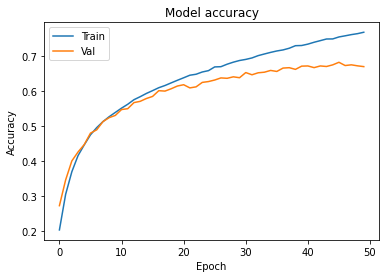

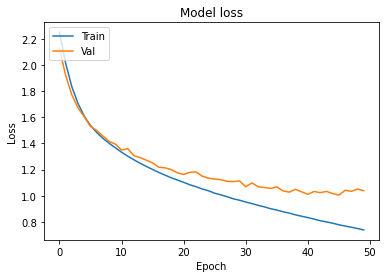

In [32]:
plot_curves(history)

#### Get predictions and find confusion matrix to get the metrics.  

(<Figure size 648x648 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1ad88df1048>)

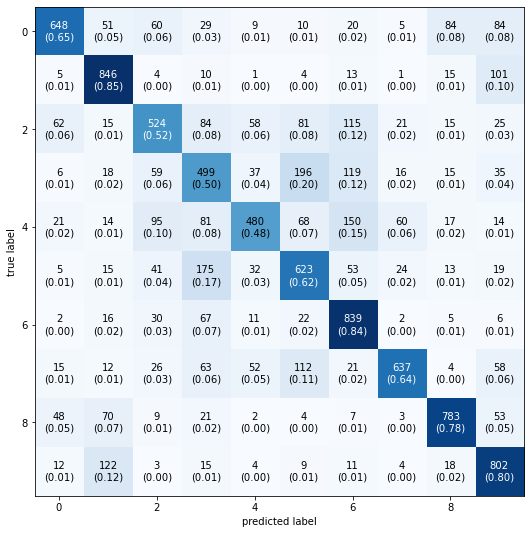

In [33]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
y_pred = model.predict_classes(X_test)
mat = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(mat,figsize=(9,9), show_normed=True)

In [34]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print(classification_report(y_pred, y_test))
print(accuracy_score(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.65      0.79      0.71       824
           1       0.85      0.72      0.78      1179
           2       0.52      0.62      0.57       851
           3       0.50      0.48      0.49      1044
           4       0.48      0.70      0.57       686
           5       0.62      0.55      0.59      1129
           6       0.84      0.62      0.71      1348
           7       0.64      0.82      0.72       773
           8       0.78      0.81      0.80       969
           9       0.80      0.67      0.73      1197

    accuracy                           0.67     10000
   macro avg       0.67      0.68      0.67     10000
weighted avg       0.69      0.67      0.67     10000

0.6681


### Trying out Batch Norm on the tuned hyperparameters. 

In [25]:
val_acc=[]
lrs=[]
l2_regs=[]
for i in tqdm(range(30)):
    lr = 10**np.random.uniform(-3,-4)
    l2_reg = 10**np.random.uniform(-6, -2)
    model = create_model(num_classes,l2_reg)
    model.compile(optimizer=optimizers.SGD(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
    history = model.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=15, verbose=1,validation_data=(X_val,y_val))
    val_acc.append(history.history['val_sparse_categorical_accuracy'][-1])
    lrs.append(lr)
    l2_regs.append(l2_reg)
    print(history.history['val_sparse_categorical_accuracy'][-1], lr, l2_reg)

  0%|          | 0/30 [00:00<?, ?it/s]

Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 8s 201us/sample - loss: 2.2884 - sparse_categorical_accuracy: 0.2066 - val_loss: 2.1869 - val_sparse_categorical_accuracy: 0.2579
Epoch 2/15
37500/37500 [==============================] - 7s 174us/sample - loss: 2.0923 - sparse_categorical_accuracy: 0.2918 - val_loss: 2.0196 - val_sparse_categorical_accuracy: 0.3151
Epoch 3/15
37500/37500 [==============================] - 6s 171us/sample - loss: 1.9393 - sparse_categorical_accuracy: 0.3471 - val_loss: 1.8835 - val_sparse_categorical_accuracy: 0.3687
Epoch 4/15
37500/37500 [==============================] - 6s 171us/sample - loss: 1.8189 - sparse_categorical_accuracy: 0.3853 - val_loss: 1.7834 - val_sparse_categorical_accuracy: 0.3987
Epoch 5/15
37500/37500 [==============================] - 6s 173us/sample - loss: 1.7265 - sparse_categorical_accuracy: 0.4185 - val_loss: 1.7033 - val_sparse_categorical_accuracy: 0.4274
Epoch 6/15

  3%|▎         | 1/30 [01:40<48:22, 100.09s/it]

0.5404 0.0007841217979144213 0.00023287114878499984
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 8s 202us/sample - loss: 2.5988 - sparse_categorical_accuracy: 0.2235 - val_loss: 2.4978 - val_sparse_categorical_accuracy: 0.2749
Epoch 2/15
37500/37500 [==============================] - 7s 176us/sample - loss: 2.4101 - sparse_categorical_accuracy: 0.2928 - val_loss: 2.3369 - val_sparse_categorical_accuracy: 0.3228
Epoch 3/15
37500/37500 [==============================] - 6s 173us/sample - loss: 2.2751 - sparse_categorical_accuracy: 0.3402 - val_loss: 2.2218 - val_sparse_categorical_accuracy: 0.3578
Epoch 4/15
37500/37500 [==============================] - 7s 174us/sample - loss: 2.1696 - sparse_categorical_accuracy: 0.3736 - val_loss: 2.1307 - val_sparse_categorical_accuracy: 0.3880
Epoch 5/15
37500/37500 [==============================] - 6s 172us/sample - loss: 2.0781 - sparse_categorical_accuracy: 0.4070 - val_loss: 2.0476 

  7%|▋         | 2/30 [03:20<46:46, 100.25s/it]

0.54056 0.0007426967555331415 0.0010876433173139918
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 8s 205us/sample - loss: 2.2480 - sparse_categorical_accuracy: 0.2227 - val_loss: 2.1218 - val_sparse_categorical_accuracy: 0.2921
Epoch 2/15
37500/37500 [==============================] - 7s 177us/sample - loss: 2.0104 - sparse_categorical_accuracy: 0.3186 - val_loss: 1.9263 - val_sparse_categorical_accuracy: 0.3432
Epoch 3/15
37500/37500 [==============================] - 7s 178us/sample - loss: 1.8539 - sparse_categorical_accuracy: 0.3662 - val_loss: 1.8027 - val_sparse_categorical_accuracy: 0.3842
Epoch 4/15
37500/37500 [==============================] - 7s 177us/sample - loss: 1.7441 - sparse_categorical_accuracy: 0.4058 - val_loss: 1.7176 - val_sparse_categorical_accuracy: 0.4129
Epoch 5/15
37500/37500 [==============================] - 7s 175us/sample - loss: 1.6574 - sparse_categorical_accuracy: 0.4339 - val_loss: 1.6334 

 10%|█         | 3/30 [05:03<45:23, 100.87s/it]

0.57496 0.0009905592866632843 0.0001501678259525072
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 8s 204us/sample - loss: 2.2909 - sparse_categorical_accuracy: 0.1365 - val_loss: 2.2697 - val_sparse_categorical_accuracy: 0.1601
Epoch 2/15
37500/37500 [==============================] - 7s 178us/sample - loss: 2.2475 - sparse_categorical_accuracy: 0.1775 - val_loss: 2.2322 - val_sparse_categorical_accuracy: 0.1888
Epoch 3/15
37500/37500 [==============================] - 7s 176us/sample - loss: 2.2095 - sparse_categorical_accuracy: 0.1974 - val_loss: 2.1944 - val_sparse_categorical_accuracy: 0.2098
Epoch 4/15
37500/37500 [==============================] - 7s 175us/sample - loss: 2.1704 - sparse_categorical_accuracy: 0.2194 - val_loss: 2.1548 - val_sparse_categorical_accuracy: 0.2322
Epoch 5/15
37500/37500 [==============================] - 7s 177us/sample - loss: 2.1295 - sparse_categorical_accuracy: 0.2430 - val_loss: 2.1135 

 13%|█▎        | 4/30 [06:45<43:53, 101.29s/it]

0.35888 0.00015934835944658767 7.368166740990548e-06
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 8s 208us/sample - loss: 2.2700 - sparse_categorical_accuracy: 0.1746 - val_loss: 2.2169 - val_sparse_categorical_accuracy: 0.2347
Epoch 2/15
37500/37500 [==============================] - 7s 177us/sample - loss: 2.1581 - sparse_categorical_accuracy: 0.2566 - val_loss: 2.0988 - val_sparse_categorical_accuracy: 0.2760
Epoch 3/15
37500/37500 [==============================] - 7s 176us/sample - loss: 2.0350 - sparse_categorical_accuracy: 0.2916 - val_loss: 1.9787 - val_sparse_categorical_accuracy: 0.3125
Epoch 4/15
37500/37500 [==============================] - 7s 178us/sample - loss: 1.9292 - sparse_categorical_accuracy: 0.3255 - val_loss: 1.8960 - val_sparse_categorical_accuracy: 0.3362
Epoch 5/15
37500/37500 [==============================] - 7s 176us/sample - loss: 1.8575 - sparse_categorical_accuracy: 0.3490 - val_loss: 1.8371

 17%|█▋        | 5/30 [08:27<42:19, 101.56s/it]

0.4672 0.0004546428156397908 1.3949373706382354e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 8s 210us/sample - loss: 2.3103 - sparse_categorical_accuracy: 0.1377 - val_loss: 2.2809 - val_sparse_categorical_accuracy: 0.1773
Epoch 2/15
37500/37500 [==============================] - 7s 177us/sample - loss: 2.2525 - sparse_categorical_accuracy: 0.1972 - val_loss: 2.2259 - val_sparse_categorical_accuracy: 0.2182
Epoch 3/15
37500/37500 [==============================] - 7s 180us/sample - loss: 2.1915 - sparse_categorical_accuracy: 0.2307 - val_loss: 2.1613 - val_sparse_categorical_accuracy: 0.2401
Epoch 4/15
37500/37500 [==============================] - 7s 177us/sample - loss: 2.1229 - sparse_categorical_accuracy: 0.2563 - val_loss: 2.0933 - val_sparse_categorical_accuracy: 0.2711
Epoch 5/15
37500/37500 [==============================] - 7s 180us/sample - loss: 2.0562 - sparse_categorical_accuracy: 0.2793 - val_loss: 2.0324 

 20%|██        | 6/30 [10:11<40:52, 102.18s/it]

0.41592 0.0002697738575297499 7.576186775303728e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 8s 210us/sample - loss: 3.0143 - sparse_categorical_accuracy: 0.1891 - val_loss: 2.9468 - val_sparse_categorical_accuracy: 0.2418
Epoch 2/15
37500/37500 [==============================] - 7s 180us/sample - loss: 2.8721 - sparse_categorical_accuracy: 0.2629 - val_loss: 2.8111 - val_sparse_categorical_accuracy: 0.2797
Epoch 3/15
37500/37500 [==============================] - 7s 178us/sample - loss: 2.7543 - sparse_categorical_accuracy: 0.2967 - val_loss: 2.7133 - val_sparse_categorical_accuracy: 0.3100
Epoch 4/15
37500/37500 [==============================] - 7s 180us/sample - loss: 2.6668 - sparse_categorical_accuracy: 0.3277 - val_loss: 2.6386 - val_sparse_categorical_accuracy: 0.3354
Epoch 5/15
37500/37500 [==============================] - 7s 178us/sample - loss: 2.5925 - sparse_categorical_accuracy: 0.3558 - val_loss: 2.5653 

 23%|██▎       | 7/30 [11:55<39:25, 102.83s/it]

0.4992 0.0005377390025946865 0.002132244697224657
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 8s 214us/sample - loss: 2.3018 - sparse_categorical_accuracy: 0.1098 - val_loss: 2.2838 - val_sparse_categorical_accuracy: 0.1383
Epoch 2/15
37500/37500 [==============================] - 7s 179us/sample - loss: 2.2662 - sparse_categorical_accuracy: 0.1717 - val_loss: 2.2529 - val_sparse_categorical_accuracy: 0.1952
Epoch 3/15
37500/37500 [==============================] - 7s 180us/sample - loss: 2.2337 - sparse_categorical_accuracy: 0.2127 - val_loss: 2.2200 - val_sparse_categorical_accuracy: 0.2250
Epoch 4/15
37500/37500 [==============================] - 7s 179us/sample - loss: 2.1984 - sparse_categorical_accuracy: 0.2349 - val_loss: 2.1838 - val_sparse_categorical_accuracy: 0.2428
Epoch 5/15
37500/37500 [==============================] - 7s 181us/sample - loss: 2.1597 - sparse_categorical_accuracy: 0.2489 - val_loss: 2.1450 - 

 27%|██▋       | 8/30 [13:39<37:53, 103.33s/it]

0.34984 0.00014513087828126216 8.401392695196019e-06
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 8s 213us/sample - loss: 2.2948 - sparse_categorical_accuracy: 0.1040 - val_loss: 2.2823 - val_sparse_categorical_accuracy: 0.1219
Epoch 2/15
37500/37500 [==============================] - 7s 183us/sample - loss: 2.2684 - sparse_categorical_accuracy: 0.1487 - val_loss: 2.2575 - val_sparse_categorical_accuracy: 0.1750
Epoch 3/15
37500/37500 [==============================] - 7s 181us/sample - loss: 2.2424 - sparse_categorical_accuracy: 0.1924 - val_loss: 2.2296 - val_sparse_categorical_accuracy: 0.2095
Epoch 4/15
37500/37500 [==============================] - 7s 182us/sample - loss: 2.2123 - sparse_categorical_accuracy: 0.2209 - val_loss: 2.1983 - val_sparse_categorical_accuracy: 0.2284
Epoch 5/15
37500/37500 [==============================] - 7s 180us/sample - loss: 2.1786 - sparse_categorical_accuracy: 0.2397 - val_loss: 2.1632

 30%|███       | 9/30 [15:25<36:21, 103.90s/it]

0.35128 0.00014955646800879807 3.905071075082133e-06
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 8s 214us/sample - loss: 2.2934 - sparse_categorical_accuracy: 0.1361 - val_loss: 2.2695 - val_sparse_categorical_accuracy: 0.1717
Epoch 2/15
37500/37500 [==============================] - 7s 182us/sample - loss: 2.2500 - sparse_categorical_accuracy: 0.2066 - val_loss: 2.2321 - val_sparse_categorical_accuracy: 0.2292
Epoch 3/15
37500/37500 [==============================] - 7s 185us/sample - loss: 2.2100 - sparse_categorical_accuracy: 0.2427 - val_loss: 2.1897 - val_sparse_categorical_accuracy: 0.2538
Epoch 4/15
37500/37500 [==============================] - 7s 183us/sample - loss: 2.1646 - sparse_categorical_accuracy: 0.2602 - val_loss: 2.1422 - val_sparse_categorical_accuracy: 0.2668
Epoch 5/15
37500/37500 [==============================] - 7s 184us/sample - loss: 2.1157 - sparse_categorical_accuracy: 0.2707 - val_loss: 2.0936

 33%|███▎      | 10/30 [17:12<35:00, 105.04s/it]

0.36768 0.00015632455890423602 2.7210487689950394e-06
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 8s 223us/sample - loss: 2.3040 - sparse_categorical_accuracy: 0.0954 - val_loss: 2.2892 - val_sparse_categorical_accuracy: 0.1045
Epoch 2/15
37500/37500 [==============================] - 7s 184us/sample - loss: 2.2753 - sparse_categorical_accuracy: 0.1270 - val_loss: 2.2636 - val_sparse_categorical_accuracy: 0.1464
Epoch 3/15
37500/37500 [==============================] - 7s 186us/sample - loss: 2.2481 - sparse_categorical_accuracy: 0.1710 - val_loss: 2.2355 - val_sparse_categorical_accuracy: 0.1884
Epoch 4/15
37500/37500 [==============================] - 7s 185us/sample - loss: 2.2177 - sparse_categorical_accuracy: 0.2093 - val_loss: 2.2041 - val_sparse_categorical_accuracy: 0.2262
Epoch 5/15
37500/37500 [==============================] - 7s 185us/sample - loss: 2.1842 - sparse_categorical_accuracy: 0.2352 - val_loss: 2.169

 37%|███▋      | 11/30 [19:02<33:40, 106.33s/it]

0.33336 0.00011061517258918635 9.664747377668961e-06
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 8s 218us/sample - loss: 2.4942 - sparse_categorical_accuracy: 0.1775 - val_loss: 2.4604 - val_sparse_categorical_accuracy: 0.2182
Epoch 2/15
37500/37500 [==============================] - 7s 182us/sample - loss: 2.4148 - sparse_categorical_accuracy: 0.2382 - val_loss: 2.3693 - val_sparse_categorical_accuracy: 0.2469
Epoch 3/15
37500/37500 [==============================] - 7s 175us/sample - loss: 2.3072 - sparse_categorical_accuracy: 0.2742 - val_loss: 2.2585 - val_sparse_categorical_accuracy: 0.2894
Epoch 4/15
37500/37500 [==============================] - 7s 177us/sample - loss: 2.2016 - sparse_categorical_accuracy: 0.3120 - val_loss: 2.1615 - val_sparse_categorical_accuracy: 0.3215
Epoch 5/15
37500/37500 [==============================] - 7s 175us/sample - loss: 2.1153 - sparse_categorical_accuracy: 0.3406 - val_loss: 2.0869

 40%|████      | 12/30 [20:44<31:34, 105.25s/it]

0.46712 0.0004047542301262614 0.0006279623485428386
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 8s 219us/sample - loss: 2.2379 - sparse_categorical_accuracy: 0.1893 - val_loss: 2.1622 - val_sparse_categorical_accuracy: 0.2495
Epoch 2/15
37500/37500 [==============================] - 7s 196us/sample - loss: 2.0822 - sparse_categorical_accuracy: 0.2667 - val_loss: 2.0192 - val_sparse_categorical_accuracy: 0.2868
Epoch 3/15
37500/37500 [==============================] - 7s 193us/sample - loss: 1.9635 - sparse_categorical_accuracy: 0.3026 - val_loss: 1.9168 - val_sparse_categorical_accuracy: 0.3217
Epoch 4/15
37500/37500 [==============================] - 7s 180us/sample - loss: 1.8719 - sparse_categorical_accuracy: 0.3361 - val_loss: 1.8355 - val_sparse_categorical_accuracy: 0.3450
Epoch 5/15
37500/37500 [==============================] - 7s 184us/sample - loss: 1.7952 - sparse_categorical_accuracy: 0.3632 - val_loss: 1.7675 

 43%|████▎     | 13/30 [22:35<30:18, 106.96s/it]

0.5076 0.0005681202663293145 5.064971321465039e-06
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 8s 225us/sample - loss: 3.2852 - sparse_categorical_accuracy: 0.1873 - val_loss: 3.1919 - val_sparse_categorical_accuracy: 0.2679
Epoch 2/15
37500/37500 [==============================] - 7s 192us/sample - loss: 3.0876 - sparse_categorical_accuracy: 0.2861 - val_loss: 3.0048 - val_sparse_categorical_accuracy: 0.3139
Epoch 3/15
37500/37500 [==============================] - 7s 187us/sample - loss: 2.9342 - sparse_categorical_accuracy: 0.3308 - val_loss: 2.8858 - val_sparse_categorical_accuracy: 0.3567
Epoch 4/15
37500/37500 [==============================] - 7s 191us/sample - loss: 2.8295 - sparse_categorical_accuracy: 0.3680 - val_loss: 2.7975 - val_sparse_categorical_accuracy: 0.3823
Epoch 5/15
37500/37500 [==============================] - 7s 190us/sample - loss: 2.7434 - sparse_categorical_accuracy: 0.3949 - val_loss: 2.7134 -

 47%|████▋     | 14/30 [24:27<28:55, 108.47s/it]

0.53064 0.0006662644515722249 0.002892506231475779
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 9s 235us/sample - loss: 3.1276 - sparse_categorical_accuracy: 0.1339 - val_loss: 3.1107 - val_sparse_categorical_accuracy: 0.1654
Epoch 2/15
37500/37500 [==============================] - 7s 194us/sample - loss: 3.0920 - sparse_categorical_accuracy: 0.1925 - val_loss: 3.0759 - val_sparse_categorical_accuracy: 0.2200
Epoch 3/15
37500/37500 [==============================] - 8s 201us/sample - loss: 3.0540 - sparse_categorical_accuracy: 0.2317 - val_loss: 3.0347 - val_sparse_categorical_accuracy: 0.2497
Epoch 4/15
37500/37500 [==============================] - 7s 199us/sample - loss: 3.0091 - sparse_categorical_accuracy: 0.2525 - val_loss: 2.9867 - val_sparse_categorical_accuracy: 0.2658
Epoch 5/15
37500/37500 [==============================] - 7s 191us/sample - loss: 2.9582 - sparse_categorical_accuracy: 0.2682 - val_loss: 2.9350 -

 50%|█████     | 15/30 [26:20<27:25, 109.70s/it]

0.388 0.00018487469941975396 0.002291525599223849
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 9s 232us/sample - loss: 2.5834 - sparse_categorical_accuracy: 0.1734 - val_loss: 2.5391 - val_sparse_categorical_accuracy: 0.2160
Epoch 2/15
37500/37500 [==============================] - 7s 192us/sample - loss: 2.4824 - sparse_categorical_accuracy: 0.2405 - val_loss: 2.4279 - val_sparse_categorical_accuracy: 0.2582
Epoch 3/15
37500/37500 [==============================] - 7s 189us/sample - loss: 2.3703 - sparse_categorical_accuracy: 0.2758 - val_loss: 2.3217 - val_sparse_categorical_accuracy: 0.2938
Epoch 4/15
37500/37500 [==============================] - 7s 186us/sample - loss: 2.2755 - sparse_categorical_accuracy: 0.3062 - val_loss: 2.2406 - val_sparse_categorical_accuracy: 0.3266
Epoch 5/15
37500/37500 [==============================] - 7s 191us/sample - loss: 2.2005 - sparse_categorical_accuracy: 0.3351 - val_loss: 2.1728 - 

 53%|█████▎    | 16/30 [28:11<25:41, 110.08s/it]

0.46704 0.0003728985478317651 0.0009009473169803427
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 8s 225us/sample - loss: 2.7493 - sparse_categorical_accuracy: 0.1180 - val_loss: 2.7254 - val_sparse_categorical_accuracy: 0.1538
Epoch 2/15
37500/37500 [==============================] - 7s 193us/sample - loss: 2.7051 - sparse_categorical_accuracy: 0.1856 - val_loss: 2.6870 - val_sparse_categorical_accuracy: 0.2069
Epoch 3/15
37500/37500 [==============================] - 8s 201us/sample - loss: 2.6644 - sparse_categorical_accuracy: 0.2235 - val_loss: 2.6437 - val_sparse_categorical_accuracy: 0.2390
Epoch 4/15
37500/37500 [==============================] - 7s 192us/sample - loss: 2.6160 - sparse_categorical_accuracy: 0.2491 - val_loss: 2.5918 - val_sparse_categorical_accuracy: 0.2581
Epoch 5/15
37500/37500 [==============================] - 7s 196us/sample - loss: 2.5605 - sparse_categorical_accuracy: 0.2681 - val_loss: 2.5358 

 57%|█████▋    | 17/30 [30:04<24:01, 110.89s/it]

0.38568 0.0001812962413464772 0.001232419729269006
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 9s 227us/sample - loss: 2.3140 - sparse_categorical_accuracy: 0.1458 - val_loss: 2.2915 - val_sparse_categorical_accuracy: 0.1666
Epoch 2/15
37500/37500 [==============================] - 8s 201us/sample - loss: 2.2713 - sparse_categorical_accuracy: 0.1794 - val_loss: 2.2523 - val_sparse_categorical_accuracy: 0.2038
Epoch 3/15
37500/37500 [==============================] - 8s 204us/sample - loss: 2.2300 - sparse_categorical_accuracy: 0.2200 - val_loss: 2.2084 - val_sparse_categorical_accuracy: 0.2381
Epoch 4/15
37500/37500 [==============================] - 8s 203us/sample - loss: 2.1819 - sparse_categorical_accuracy: 0.2475 - val_loss: 2.1579 - val_sparse_categorical_accuracy: 0.2581
Epoch 5/15
37500/37500 [==============================] - 7s 197us/sample - loss: 2.1286 - sparse_categorical_accuracy: 0.2609 - val_loss: 2.1054 -

 60%|██████    | 18/30 [32:08<22:58, 114.86s/it]

0.38168 0.00016101543782624333 5.764489667236756e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 10s 272us/sample - loss: 2.3623 - sparse_categorical_accuracy: 0.1157 - val_loss: 2.3322 - val_sparse_categorical_accuracy: 0.1497
Epoch 2/15
37500/37500 [==============================] - 8s 219us/sample - loss: 2.3117 - sparse_categorical_accuracy: 0.1793 - val_loss: 2.2961 - val_sparse_categorical_accuracy: 0.1990
Epoch 3/15
37500/37500 [==============================] - 8s 220us/sample - loss: 2.2748 - sparse_categorical_accuracy: 0.2162 - val_loss: 2.2589 - val_sparse_categorical_accuracy: 0.2268
Epoch 4/15
37500/37500 [==============================] - 8s 220us/sample - loss: 2.2357 - sparse_categorical_accuracy: 0.2390 - val_loss: 2.2189 - val_sparse_categorical_accuracy: 0.2462
Epoch 5/15
37500/37500 [==============================] - 8s 216us/sample - loss: 2.1942 - sparse_categorical_accuracy: 0.2545 - val_loss: 2.177

 63%|██████▎   | 19/30 [34:14<21:41, 118.27s/it]

0.36288 0.00014763271556268004 0.00015654134314587074
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 9s 244us/sample - loss: 2.2837 - sparse_categorical_accuracy: 0.1277 - val_loss: 2.2589 - val_sparse_categorical_accuracy: 0.1650
Epoch 2/15
37500/37500 [==============================] - 8s 203us/sample - loss: 2.2330 - sparse_categorical_accuracy: 0.1939 - val_loss: 2.2107 - val_sparse_categorical_accuracy: 0.2153
Epoch 3/15
37500/37500 [==============================] - 8s 202us/sample - loss: 2.1817 - sparse_categorical_accuracy: 0.2221 - val_loss: 2.1571 - val_sparse_categorical_accuracy: 0.2349
Epoch 4/15
37500/37500 [==============================] - 8s 203us/sample - loss: 2.1260 - sparse_categorical_accuracy: 0.2382 - val_loss: 2.1017 - val_sparse_categorical_accuracy: 0.2538
Epoch 5/15
37500/37500 [==============================] - 8s 204us/sample - loss: 2.0705 - sparse_categorical_accuracy: 0.2659 - val_loss: 2.048

 67%|██████▋   | 20/30 [36:16<19:52, 119.24s/it]

0.39296 0.0002027142867071907 2.5213585100763462e-06
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 9s 248us/sample - loss: 2.3079 - sparse_categorical_accuracy: 0.1183 - val_loss: 2.2879 - val_sparse_categorical_accuracy: 0.1551
Epoch 2/15
37500/37500 [==============================] - 8s 201us/sample - loss: 2.2729 - sparse_categorical_accuracy: 0.1799 - val_loss: 2.2593 - val_sparse_categorical_accuracy: 0.1982
Epoch 3/15
37500/37500 [==============================] - 8s 201us/sample - loss: 2.2425 - sparse_categorical_accuracy: 0.2169 - val_loss: 2.2272 - val_sparse_categorical_accuracy: 0.2302
Epoch 4/15
37500/37500 [==============================] - 8s 201us/sample - loss: 2.2065 - sparse_categorical_accuracy: 0.2463 - val_loss: 2.1879 - val_sparse_categorical_accuracy: 0.2512
Epoch 5/15
37500/37500 [==============================] - 8s 203us/sample - loss: 2.1630 - sparse_categorical_accuracy: 0.2615 - val_loss: 2.1415

 70%|███████   | 21/30 [38:13<17:49, 118.81s/it]

0.368 0.00014853317526523015 2.2086499058643194e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 9s 243us/sample - loss: 2.2947 - sparse_categorical_accuracy: 0.1358 - val_loss: 2.2662 - val_sparse_categorical_accuracy: 0.1704
Epoch 2/15
37500/37500 [==============================] - 8s 204us/sample - loss: 2.2402 - sparse_categorical_accuracy: 0.1992 - val_loss: 2.2153 - val_sparse_categorical_accuracy: 0.2135
Epoch 3/15
37500/37500 [==============================] - 8s 206us/sample - loss: 2.1832 - sparse_categorical_accuracy: 0.2301 - val_loss: 2.1543 - val_sparse_categorical_accuracy: 0.2389
Epoch 4/15
37500/37500 [==============================] - 7s 194us/sample - loss: 2.1187 - sparse_categorical_accuracy: 0.2566 - val_loss: 2.0898 - val_sparse_categorical_accuracy: 0.2698
Epoch 5/15
37500/37500 [==============================] - 7s 199us/sample - loss: 2.0545 - sparse_categorical_accuracy: 0.2834 - val_loss: 2.0289 

 73%|███████▎  | 22/30 [40:09<15:43, 117.89s/it]

0.40328 0.000200236844103105 2.0215190296146457e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 9s 237us/sample - loss: 4.0617 - sparse_categorical_accuracy: 0.1939 - val_loss: 3.9461 - val_sparse_categorical_accuracy: 0.2733
Epoch 2/15
37500/37500 [==============================] - 7s 190us/sample - loss: 3.8054 - sparse_categorical_accuracy: 0.2947 - val_loss: 3.6824 - val_sparse_categorical_accuracy: 0.3305
Epoch 3/15
37500/37500 [==============================] - 7s 193us/sample - loss: 3.5889 - sparse_categorical_accuracy: 0.3515 - val_loss: 3.5162 - val_sparse_categorical_accuracy: 0.3761
Epoch 4/15
37500/37500 [==============================] - 7s 190us/sample - loss: 3.4432 - sparse_categorical_accuracy: 0.3901 - val_loss: 3.3892 - val_sparse_categorical_accuracy: 0.4071
Epoch 5/15
37500/37500 [==============================] - 7s 192us/sample - loss: 3.3280 - sparse_categorical_accuracy: 0.4215 - val_loss: 3.2824 

 77%|███████▋  | 23/30 [42:01<13:32, 116.10s/it]

0.54752 0.0009592861537017728 0.005011564098950385
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 9s 246us/sample - loss: 2.3342 - sparse_categorical_accuracy: 0.1326 - val_loss: 2.3085 - val_sparse_categorical_accuracy: 0.1744
Epoch 2/15
37500/37500 [==============================] - 7s 187us/sample - loss: 2.2806 - sparse_categorical_accuracy: 0.1948 - val_loss: 2.2579 - val_sparse_categorical_accuracy: 0.2136
Epoch 3/15
37500/37500 [==============================] - 7s 190us/sample - loss: 2.2247 - sparse_categorical_accuracy: 0.2329 - val_loss: 2.1985 - val_sparse_categorical_accuracy: 0.2542
Epoch 4/15
37500/37500 [==============================] - 7s 187us/sample - loss: 2.1642 - sparse_categorical_accuracy: 0.2613 - val_loss: 2.1398 - val_sparse_categorical_accuracy: 0.2746
Epoch 5/15
37500/37500 [==============================] - 7s 190us/sample - loss: 2.1073 - sparse_categorical_accuracy: 0.2774 - val_loss: 2.0871 -

 80%|████████  | 24/30 [44:02<11:46, 117.70s/it]

0.40016 0.00021687363652744015 0.00014428078259206786
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 10s 271us/sample - loss: 2.4565 - sparse_categorical_accuracy: 0.1950 - val_loss: 2.3847 - val_sparse_categorical_accuracy: 0.2462
Epoch 2/15
37500/37500 [==============================] - 9s 227us/sample - loss: 2.2890 - sparse_categorical_accuracy: 0.2726 - val_loss: 2.2116 - val_sparse_categorical_accuracy: 0.3011
Epoch 3/15
37500/37500 [==============================] - 8s 212us/sample - loss: 2.1331 - sparse_categorical_accuracy: 0.3265 - val_loss: 2.0789 - val_sparse_categorical_accuracy: 0.3466
Epoch 4/15
37500/37500 [==============================] - 8s 225us/sample - loss: 2.0092 - sparse_categorical_accuracy: 0.3741 - val_loss: 1.9692 - val_sparse_categorical_accuracy: 0.3929
Epoch 5/15
37500/37500 [==============================] - 8s 204us/sample - loss: 1.9139 - sparse_categorical_accuracy: 0.4069 - val_loss: 1.88

 83%|████████▎ | 25/30 [46:06<09:56, 119.38s/it]

0.54264 0.0007316829163605394 0.000596736025335764
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 9s 252us/sample - loss: 2.2462 - sparse_categorical_accuracy: 0.1945 - val_loss: 2.1803 - val_sparse_categorical_accuracy: 0.2362
Epoch 2/15
37500/37500 [==============================] - 8s 215us/sample - loss: 2.1000 - sparse_categorical_accuracy: 0.2650 - val_loss: 2.0347 - val_sparse_categorical_accuracy: 0.2978
Epoch 3/15
37500/37500 [==============================] - 7s 192us/sample - loss: 1.9736 - sparse_categorical_accuracy: 0.3116 - val_loss: 1.9293 - val_sparse_categorical_accuracy: 0.3280
Epoch 4/15
37500/37500 [==============================] - 8s 202us/sample - loss: 1.8748 - sparse_categorical_accuracy: 0.3446 - val_loss: 1.8443 - val_sparse_categorical_accuracy: 0.3582
Epoch 5/15
37500/37500 [==============================] - 8s 208us/sample - loss: 1.7976 - sparse_categorical_accuracy: 0.3728 - val_loss: 1.7734 -

 87%|████████▋ | 26/30 [48:09<08:02, 120.61s/it]

0.50704 0.0005572868152845399 3.557846301314022e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 10s 260us/sample - loss: 2.3022 - sparse_categorical_accuracy: 0.1345 - val_loss: 2.2706 - val_sparse_categorical_accuracy: 0.1723
Epoch 2/15
37500/37500 [==============================] - 8s 203us/sample - loss: 2.2479 - sparse_categorical_accuracy: 0.1914 - val_loss: 2.2269 - val_sparse_categorical_accuracy: 0.2075
Epoch 3/15
37500/37500 [==============================] - 8s 203us/sample - loss: 2.2027 - sparse_categorical_accuracy: 0.2286 - val_loss: 2.1814 - val_sparse_categorical_accuracy: 0.2433
Epoch 4/15
37500/37500 [==============================] - 8s 211us/sample - loss: 2.1553 - sparse_categorical_accuracy: 0.2584 - val_loss: 2.1338 - val_sparse_categorical_accuracy: 0.2599
Epoch 5/15
37500/37500 [==============================] - 8s 203us/sample - loss: 2.1063 - sparse_categorical_accuracy: 0.2733 - val_loss: 2.0853

 90%|█████████ | 27/30 [50:10<06:02, 120.67s/it]

0.38608 0.00015482674766941374 2.127074862600129e-06
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 10s 270us/sample - loss: 2.4151 - sparse_categorical_accuracy: 0.0985 - val_loss: 2.3903 - val_sparse_categorical_accuracy: 0.1150
Epoch 2/15
37500/37500 [==============================] - 8s 200us/sample - loss: 2.3706 - sparse_categorical_accuracy: 0.1342 - val_loss: 2.3597 - val_sparse_categorical_accuracy: 0.1481
Epoch 3/15
37500/37500 [==============================] - 7s 196us/sample - loss: 2.3418 - sparse_categorical_accuracy: 0.1661 - val_loss: 2.3325 - val_sparse_categorical_accuracy: 0.1816
Epoch 4/15
37500/37500 [==============================] - 7s 198us/sample - loss: 2.3138 - sparse_categorical_accuracy: 0.1981 - val_loss: 2.3042 - val_sparse_categorical_accuracy: 0.2104
Epoch 5/15
37500/37500 [==============================] - 7s 195us/sample - loss: 2.2836 - sparse_categorical_accuracy: 0.2227 - val_loss: 2.273

 93%|█████████▎| 28/30 [52:09<04:00, 120.03s/it]

0.34168 0.00010161046478876636 0.00025831567706354657
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 9s 245us/sample - loss: 2.2662 - sparse_categorical_accuracy: 0.1834 - val_loss: 2.2048 - val_sparse_categorical_accuracy: 0.2434
Epoch 2/15
37500/37500 [==============================] - 7s 197us/sample - loss: 2.1269 - sparse_categorical_accuracy: 0.2625 - val_loss: 2.0576 - val_sparse_categorical_accuracy: 0.2843
Epoch 3/15
37500/37500 [==============================] - 7s 196us/sample - loss: 1.9901 - sparse_categorical_accuracy: 0.3011 - val_loss: 1.9416 - val_sparse_categorical_accuracy: 0.3278
Epoch 4/15
37500/37500 [==============================] - 7s 193us/sample - loss: 1.8925 - sparse_categorical_accuracy: 0.3345 - val_loss: 1.8660 - val_sparse_categorical_accuracy: 0.3484
Epoch 5/15
37500/37500 [==============================] - 8s 201us/sample - loss: 1.8236 - sparse_categorical_accuracy: 0.3591 - val_loss: 1.804

 97%|█████████▋| 29/30 [54:06<01:59, 119.24s/it]

0.49392 0.0005079343288002167 2.768743739871422e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 9s 235us/sample - loss: 2.4806 - sparse_categorical_accuracy: 0.1236 - val_loss: 2.4359 - val_sparse_categorical_accuracy: 0.1793
Epoch 2/15
37500/37500 [==============================] - 7s 196us/sample - loss: 2.3978 - sparse_categorical_accuracy: 0.2131 - val_loss: 2.3639 - val_sparse_categorical_accuracy: 0.2423
Epoch 3/15
37500/37500 [==============================] - 7s 193us/sample - loss: 2.3260 - sparse_categorical_accuracy: 0.2531 - val_loss: 2.2951 - val_sparse_categorical_accuracy: 0.2672
Epoch 4/15
37500/37500 [==============================] - 8s 219us/sample - loss: 2.2608 - sparse_categorical_accuracy: 0.2742 - val_loss: 2.2361 - val_sparse_categorical_accuracy: 0.2868
Epoch 5/15
37500/37500 [==============================] - 8s 216us/sample - loss: 2.2058 - sparse_categorical_accuracy: 0.2917 - val_loss: 2.1860 

100%|██████████| 30/30 [56:07<00:00, 112.26s/it]

0.40168 0.00018117736516382697 0.0005318784683181312


In [26]:
logs=[val_acc,lrs, l2_regs]
logs=np.array(logs)
# logs=np.sort(logs,axis=0)

In [27]:
top4=np.argsort(logs[0,:])[::-1][:4]
top4

array([ 2, 22, 24,  1], dtype=int64)

In [28]:
logs[:,top4]

array([[5.74959993e-01, 5.47519982e-01, 5.42639971e-01, 5.40560007e-01],
       [9.90559287e-04, 9.59286154e-04, 7.31682916e-04, 7.42696756e-04],
       [1.50167826e-04, 5.01156410e-03, 5.96736025e-04, 1.08764332e-03]])

In [29]:
lr, l2_reg = logs[1,top4[0]],logs[2,top4[0]]
lr, l2_reg

(0.0009905592866632843, 0.0001501678259525072)

In [30]:
lr_tuned, l2_reg_tuned = lr, l2_reg
lr_tuned, l2_reg_tuned

(0.0009905592866632843, 0.0001501678259525072)

In [72]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model = create_model(num_classes,l2_reg_tuned, False, True)
model.compile(optimizer=optimizers.SGD(learning_rate=lr_tuned),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
history = model.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=50, verbose=1,validation_data=(X_val,y_val), callbacks=[es])

Train on 50000 samples, validate on 12500 samples
Epoch 1/50
50000/50000 [==============================] - 31s 623us/sample - loss: 2.2618 - sparse_categorical_accuracy: 0.3763 - val_loss: 1.9606 - val_sparse_categorical_accuracy: 0.4856
Epoch 2/50
50000/50000 [==============================] - 24s 475us/sample - loss: 1.9149 - sparse_categorical_accuracy: 0.4992 - val_loss: 1.7755 - val_sparse_categorical_accuracy: 0.5578
Epoch 3/50
50000/50000 [==============================] - 23s 457us/sample - loss: 1.7690 - sparse_categorical_accuracy: 0.5543 - val_loss: 1.6665 - val_sparse_categorical_accuracy: 0.6010
Epoch 4/50
50000/50000 [==============================] - 23s 455us/sample - loss: 1.6702 - sparse_categorical_accuracy: 0.5910 - val_loss: 1.5722 - val_sparse_categorical_accuracy: 0.6292
Epoch 5/50
50000/50000 [==============================] - 23s 454us/sample - loss: 1.6011 - sparse_categorical_accuracy: 0.6150 - val_loss: 1.5240 - val_sparse_categorical_accuracy: 0.6465
Epoch

Epoch 44/50
50000/50000 [==============================] - 23s 452us/sample - loss: 0.7146 - sparse_categorical_accuracy: 0.8964 - val_loss: 0.6325 - val_sparse_categorical_accuracy: 0.9330
Epoch 45/50
50000/50000 [==============================] - 23s 455us/sample - loss: 0.7014 - sparse_categorical_accuracy: 0.9024 - val_loss: 0.6149 - val_sparse_categorical_accuracy: 0.9386
Epoch 46/50
50000/50000 [==============================] - 23s 451us/sample - loss: 0.6889 - sparse_categorical_accuracy: 0.9060 - val_loss: 0.6218 - val_sparse_categorical_accuracy: 0.9360
Epoch 47/50
50000/50000 [==============================] - 23s 455us/sample - loss: 0.6751 - sparse_categorical_accuracy: 0.9090 - val_loss: 0.6039 - val_sparse_categorical_accuracy: 0.9407
Epoch 48/50
50000/50000 [==============================] - 23s 451us/sample - loss: 0.6647 - sparse_categorical_accuracy: 0.9110 - val_loss: 0.5932 - val_sparse_categorical_accuracy: 0.9450
Epoch 49/50
50000/50000 [=========================

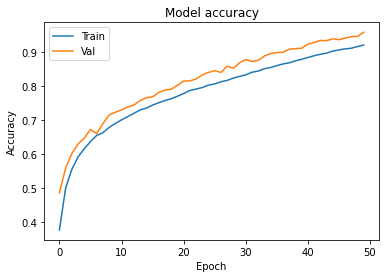

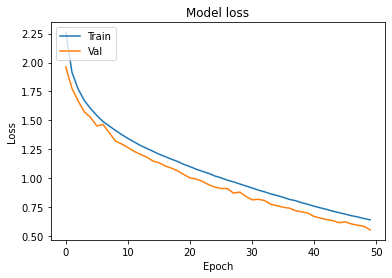

In [73]:
plot_curves(history)

              precision    recall  f1-score   support

           0       0.75      0.75      0.75      1000
           1       0.79      0.87      0.83       902
           2       0.61      0.63      0.62       970
           3       0.51      0.56      0.53       899
           4       0.73      0.68      0.70      1087
           5       0.68      0.57      0.62      1200
           6       0.78      0.81      0.79       960
           7       0.76      0.79      0.78       956
           8       0.83      0.84      0.83       995
           9       0.81      0.79      0.80      1031

    accuracy                           0.72     10000
   macro avg       0.72      0.73      0.73     10000
weighted avg       0.73      0.72      0.72     10000

0.7244


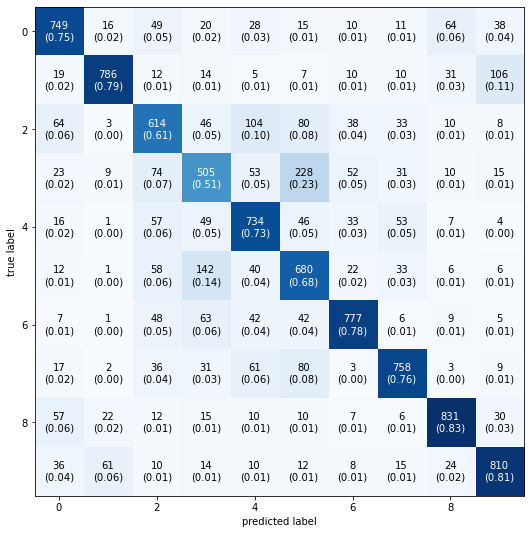

In [74]:
y_pred = model.predict_classes(X_test)
mat = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(mat,figsize=(9,9), show_normed=True)
print(classification_report(y_pred, y_test))
print(accuracy_score(y_pred, y_test))

### Check the effect of Data Preprocessing on the training. 
Repeated the procedure with the preprocess flag changed to false.  

In [75]:
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
#conv to float
(X_train, y_train), (X_test, y_test)=(X_train.astype('float64'), y_train), (X_test.astype('float64'), y_test)
#class_names for cifar
class_name = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
preprocess_flag=False

In [76]:
if preprocess_flag==True:
    X_train, X_test=preprocess_data(X_train, X_test)

In [77]:
#model hyperparam
LEARNING_RATE=1e-4
EPOCHS=10
L2_REG=0

In [78]:
model=create_model(num_classes,L2_REG)
model.summary()

Model: "sequential_285"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_855 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_855 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_856 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_856 (MaxPoolin (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_857 (Conv2D)          (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_857 (MaxPoolin (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_285 (Flatten)        (None, 2048)           

In [81]:
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
model.evaluate(X_train,y_train)

50000/50000 [==============================] - 18s 353us/sample - loss: 28.3447 - sparse_categorical_accuracy: 0.0990


[28.344733353271483, 0.09904]